In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from scipy import stats, spatial
from sklearn import preprocessing, manifold, decomposition
import processing
import umap, hdbscan

In [3]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import statsmodels.api as sm

In [4]:
words = pd.read_csv('./data/words.csv')

In [5]:
log = pd.read_csv('./data/log_sample_processed.csv')

In [144]:
participants = pd.read_csv('./data/participants_processed.csv',index_col=0)

## Data preparation

### Log

In [5]:
%%time
log_sample = processing.get_participants_for_log(log_sample)

CPU times: user 4.72 s, sys: 2.35 s, total: 7.07 s
Wall time: 7.82 s


In [6]:
log_sample.shape

(7212018, 10)

In [7]:
%%time
log = processing.log_process(log_sample)

CPU times: user 3min 3s, sys: 10.3 s, total: 3min 13s
Wall time: 3min 20s


In [8]:
%%time
log = processing.mark_entries(log)

CPU times: user 3min 44s, sys: 5.12 s, total: 3min 49s
Wall time: 3min 51s


In [ ]:
%% time
log = processing.filter_log(log)

#### ITEs (Phase 1)

In [15]:
log = processing.infer_ite_no_swype(log)

In [18]:
log = processing.infer_sub_strategy(log)

In [19]:
log.ite.value_counts(normalize=True)

none        0.977699
autocorr    0.014792
predict     0.007509
Name: ite, dtype: float64

In [20]:
log.ite2.value_counts(normalize=True)

completion    0.612237
correction    0.301064
prediction    0.033524
no_change     0.030154
none          0.018206
fixup         0.004814
Name: ite2, dtype: float64

In [21]:
log.to_csv('./data/log_sample_processed.csv',index=False)

### Words

#### ITE's (Phase 2)

In [9]:
# Contractions
mask = words.ite == 'predict'
mask &= words.ite_lev_dist == 1
mask &= words.ite_len_diff == 1
mask &= words.ite_input_key.str.contains("'")
mask &= ~words.loc[mask].ite_input_prev.str.contains("'")
words.loc[mask,'ite2'] = 'contraction'

# Capitalizations
mask = words.ite == 'predict'
mask &= words.ite_lev_dist == 0
mask &= words.ite_len_diff == 0
mask &= words.ite_input_prev.str.contains('^[a-z]+$')
mask &= words.ite_input_key.str.contains('[A-Z]')
words.loc[mask,'ite2'] = 'capitalization'

# Remove the no changes that actually have changes
mask = words.ite2 == 'no_change'
mask &= words.ite_input != words.ite_input_prev
words.loc[mask,'ite2'] = 'none'

# A lot of the "none" ite2 is actually an added space
mask = words.ite_input_key.str.split().str.len() > 1 # Ite input has more than one word
mask &= words.ite_input_key.str.replace(' ','') == words.ite_input_prev # After removing spaces, should equal previous text field
words.loc[mask, 'ite2'] = 'add_space'

# Stratergic use: User changed the word after using prediction
words['strategic'] = None
# Default is False for all predictions
words.loc[words.ite == 'predict','strategic'] = 'none'
# Mask: prediction where the selected suggestion was not the final word
mask = words.ite == 'predict'
mask &= words.word != words.ite_input
# mask &= words.loc[mask].apply(lambda x: x.word not in x.ite_input,axis=1) # Remove the ite entries that involve multiple words

# Case 1: User changes the keys, but the prefix is the same 
mask1 = mask.copy()
mask1 &= (~words.strategic.isin(['add','remove']))
mask1 &= words.loc[mask].apply(lambda x: (x.ite_input_prev in x.word) and (x.ite_input_prev in x.ite_input),axis=1)
words.loc[mask1,'strategic'] = 'same_prefix'

# Case 2: User adds keys after prediction
mask2 = mask.copy()
mask2 &= words.loc[mask].apply(lambda x: x.ite_input in x.word,axis=1)
words.loc[mask2,'strategic'] = 'add'

# Case 3: User removes keys after prediction
mask3 = mask.copy()
mask3 &= words.loc[mask].apply(lambda x: x.word in x.ite_input,axis=1)
words.loc[mask3,'strategic'] = 'remove'

# Case 4: Other
mask4 = mask.copy()
mask4 &= (~words.strategic.isin(['add','remove','same_prefix']))
words.loc[mask4,'strategic'] = 'other'

In [10]:
words.to_csv('./data/words.csv',index=False)

In [11]:
words.strategic.value_counts(normalize=True)

none           0.934070
add            0.029179
other          0.017774
remove         0.012340
same_prefix    0.006638
Name: strategic, dtype: float64

In [12]:
words.ite2.value_counts(normalize=True)

completion        0.609919
correction        0.280274
prediction        0.033640
capitalization    0.025908
contraction       0.025685
none              0.013909
fixup             0.004755
add_space         0.003688
no_change         0.002222
Name: ite2, dtype: float64

### Participants

In [30]:
participants_ = processing.get_participants().set_index('PARTICIPANT_ID')
participants_ = participants_.loc[words.participant_id.unique()].copy()

In [31]:
participants_['hands2'] = participants_.FINGERS.str.split(';').str[0]
participants_['hands1'] = participants_.hands2.map({'left_hand':'one_hand','right_hand':'one_hand','both_hands':'both_hands'})

In [32]:
def to_numeric(x):
    try:
        ret = float(x)
    except:
        ret = np.nan
    return ret
participants_.TIME_SPENT_TYPING = participants_.TIME_SPENT_TYPING.apply(to_numeric)

In [33]:
participants = pd.DataFrame()
participants['id'] = words.participant_id.unique()
participants.set_index('id',inplace=True)
participants['n_words'] = words.groupby(['participant_id']).size()
participants['n_predict'] = words.groupby(['participant_id','ite']).size().unstack()['predict'].fillna(0)
participants['n_autocorr'] = words.groupby(['participant_id','ite']).size().unstack()['autocorr'].fillna(0)

# Rate of ite usage
participants_ite = words.groupby('participant_id').ite.value_counts(normalize=True).unstack()
participants_ite.fillna(0,inplace=True)

# Rate of ite2
participants_ite2 = words.groupby('participant_id').ite2.value_counts(normalize=True).unstack()
participants_ite2.fillna(0,inplace=True)

# Frequency categories
data1 = words.groupby(['participant_id','ite']).freq_category.value_counts(normalize=True).unstack(1)['predict'].unstack()
data2 = words.groupby('participant_id').freq_category.value_counts(normalize=True).unstack()
participants_freq = data1.fillna(0)
participants_freq_relative = (participants_freq / data2).fillna(0)

# Frequency numerical
data = words.copy()
data.freq = np.log10(words.freq)
data1 = data.groupby(['participant_id','ite']).freq.mean().unstack()['predict']
data2 = data.groupby('participant_id').freq.mean()
participants_freq_numeral_relative = (data1 / data2).fillna(1)

# Normalized word length
data = words.loc[words.word_length > 0]
data1 = data.groupby(['participant_id','ite']).ite_input_len.median().unstack()['predict']
data2 = data.groupby('participant_id').word_length.median()
participants_len = (data1 / data2).fillna(0)

data1 = data.groupby(['participant_id','ite']).ite_input_len.std().unstack()['predict']
data2 = data.groupby('participant_id').word_length.std()
participants_len_pref = (data1 / data2).fillna(0)

# Lev_dist
participants_lev_dist = words.groupby(['participant_id','ite']).ite_lev_dist.median().unstack().fillna(0)['predict']


# Lev ratio
words['ite_lev_ratio'] = words.ite_lev_dist / words.ite_input_len
participants_lev_ratio = words.groupby(['participant_id','ite']).ite_lev_ratio.median().unstack().fillna(0)['predict']
participants_lev_ratio_pref = words.groupby(['participant_id','ite']).ite_lev_ratio.std().unstack().fillna(0)['predict']

# Speed
mask = (log.len_diff == 1) & (log.is_forward)
mask &= (log.key.str.contains('[A-Za-z]')) & (log.key.shift(1).str.contains('[A-Za-z]'))
participants_speed = log.loc[mask].groupby('participant_id').iki.median()

# Fingers
participants_fingers = participants_.FINGERS.str.split(';').str[0]
participants_fingers = participants_fingers.map({
    'both_hands': 1,
    'right_hand': 0,
    'left_hand': 0,
    'undefined': 1
})

In [36]:
participants_.to_csv('./data/participants_processed.csv',index=True)

## For what words is prediction used?

### Global analysis

Let's look at some general characteristics of prediction usage

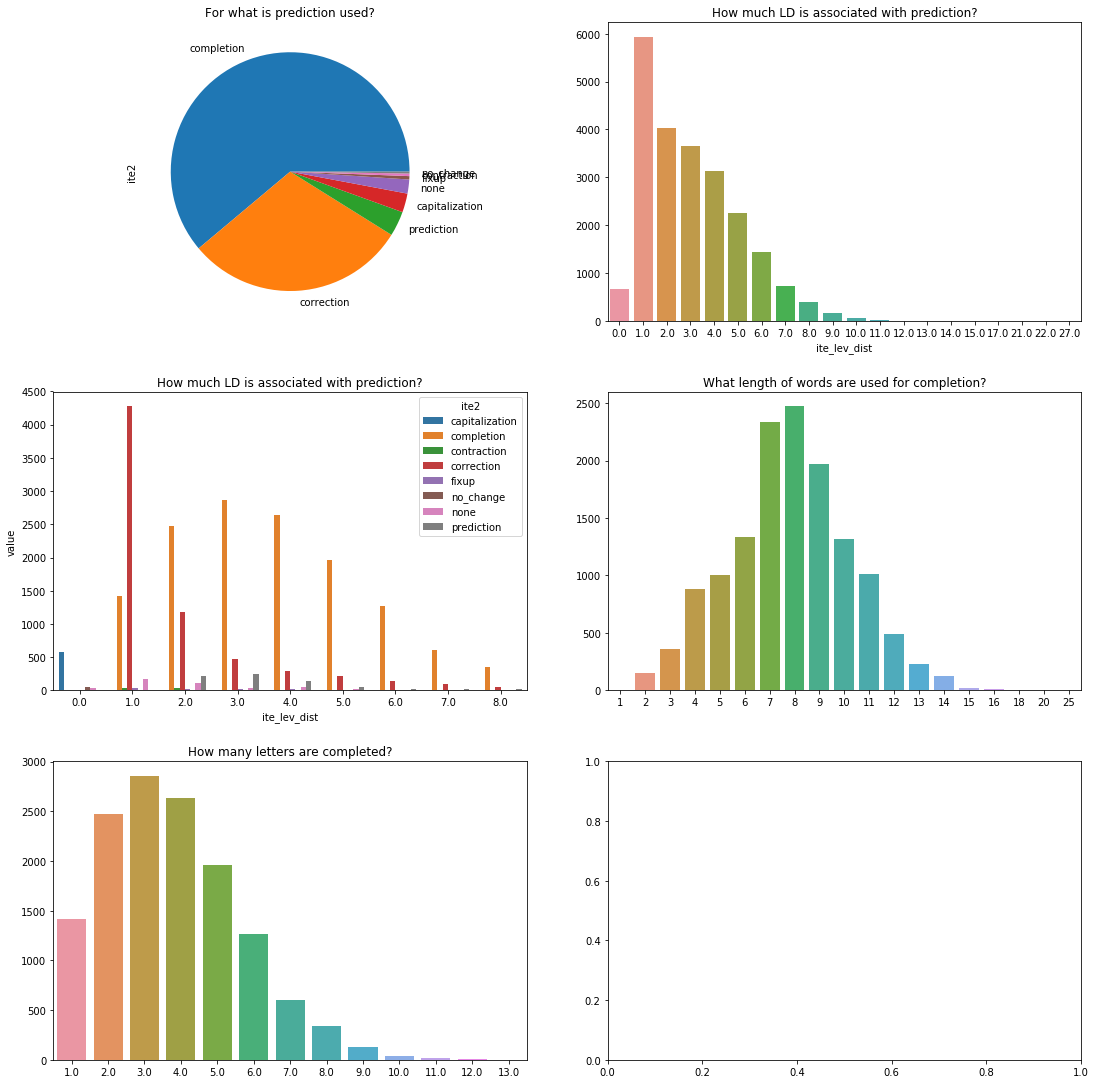

In [11]:
f,ax = plt.subplots(3,2,figsize=(15,15))
ax1,ax2,ax3,ax4,ax5,ax6=ax.flatten()

f.tight_layout(w_pad=5,h_pad=5)

ax1.set_title('For what is prediction used?')
data = words.loc[words.ite == 'predict']
data.ite2.value_counts(normalize=True).plot.pie(ax=ax1)
ax1.set_aspect('equal')

ax2.set_title('How much LD is associated with prediction?')
data = words.loc[words.ite == 'predict']
data = data.groupby('ite_lev_dist').size()
sns.barplot(data.index,data.values,ax=ax2)

ax3.set_title('How much LD is associated with prediction?')
data = words.loc[words.ite == 'predict']
data = data.loc[data.ite_lev_dist < 9]
data = data.groupby(['ite_lev_dist','ite2']).size().unstack().reset_index().melt('ite_lev_dist')
sns.barplot(data.ite_lev_dist,data.value,hue=data.ite2,ax=ax3)

ax4.set_title('What length of words are used for completion?')
data = words.loc[words.ite2 == 'completion']
data = data.ite_input.str.len().value_counts()
sns.barplot(data.index,data.values,ax=ax4)

ax5.set_title('How many letters are completed?')
data = words.loc[words.ite2 == 'completion']
data = data.ite_lev_dist.value_counts()
sns.barplot(data.index,data.values,ax=ax5)

### Is prediction used for certain words more than for others?

Text(63.125,0.5,'Probability')

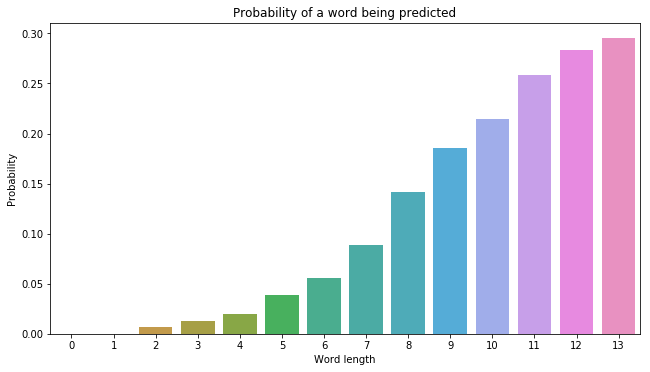

In [311]:
f,ax = plt.subplots(1,1,figsize=(10,6))
ax1 = ax

f.tight_layout(pad = 5)
ax1.set_title('Probability of a word being predicted')

# In the case of ITE, the input is equal to the final word
mask = (words.ite_input == words.word) | (words.ite == 'none')
# Very long words don't occur enough times to make a conclusion
data = words.loc[(words.word_length < 14) & mask]
data = data.groupby('word_length').ite.value_counts(normalize=True).unstack()['predict']
sns.barplot(data.index,data.values,ax=ax1)
ax1.set_xlabel('Word length')
ax1.set_ylabel('Probability')

In [ ]:
f.savefig('./figures/length_predict_probability.png',dpi=300)

Text(63.125,0.5,'Probability')

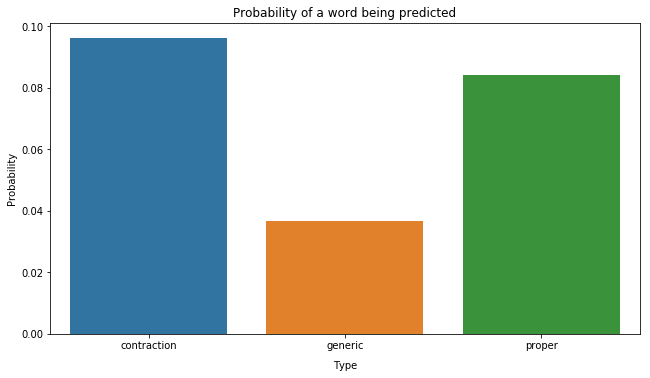

In [312]:
f,ax = plt.subplots(1,1,figsize=(10,6))
ax1 = ax

f.tight_layout(pad = 5)
ax1.set_title('Probability of a word being predicted')

# In the case of ITE, the input is equal to the final word
mask = (words.ite_input == words.word) | (words.ite == 'none')
# Very long words don't occur enough times to make a conclusion
data = words.loc[(words.word_length < 13) & mask]
data = data.groupby('type').ite.value_counts(normalize=True).unstack()['predict']
sns.barplot(data.index,data.values,ax=ax1)
ax1.set_xlabel('Type',labelpad=10)
ax1.set_ylabel('Probability')

In [ ]:
f.savefig('./figures/type_predict_probability.png',dpi=300)

Text(0,0.5,'Probability')

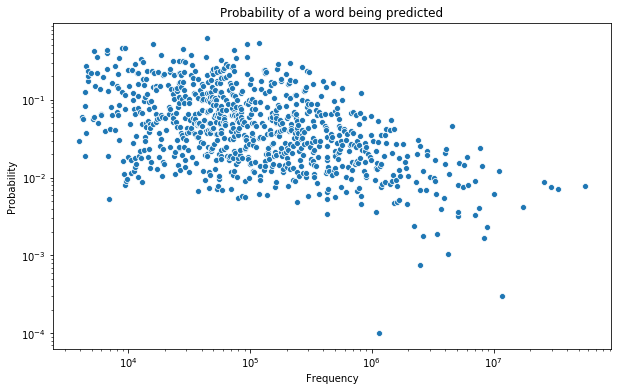

In [323]:
f,ax = plt.subplots(1,1,figsize=(10,6))
ax1 = ax

ax1.set_title('Probability of a word being predicted')
ax1.set_xscale('log')
ax1.set_yscale('log')

# In the case of ITE, the input is equal to the final word
mask = (words.ite_input == words.word) | (words.ite == 'none')
data = words.loc[(words.word_length < 13) & mask]
data = data.groupby('freq').ite.value_counts(normalize=True).unstack()['predict']
data = data.loc[words.groupby('freq').size() > 50]
data = data.reset_index()
sns.scatterplot(data.freq,data.predict,ax=ax1)

ax1.set_xlabel('Frequency')
ax1.set_ylabel('Probability')


In [ ]:
f.savefig('./figures/freq_predict_probability.png',dpi=300)

#### Measuring effort

In [13]:
qwerty = [
    'qwertyuiop',
    'asdfghjkl',
    'zxcvbnm'
]
tmp = qwerty
for i,line in enumerate(tmp):
    qwerty[i] = list(line)
    
tmp = qwerty
qwerty = {}
# Invert so we have indices
for i,line in enumerate(tmp):
    for j,char in enumerate(line):
        qwerty[char] = [i,j]
qwerty = pd.DataFrame(qwerty).T
# Offset the rows
qwerty.loc[qwerty[0] == 1, 1] += 0.5
qwerty.loc[qwerty[0] == 2, 1] += 1.5

qwerty_dist = spatial.distance_matrix(qwerty,qwerty,p=1)
qwerty_dist = pd.DataFrame(qwerty_dist,index=qwerty.index,columns=qwerty.index)

# Flatten
tmp = qwerty_dist.copy()
qwerty_dist = {}
for i in tmp.index:
    for j in tmp.columns:
        qwerty_dist[i+j] = tmp.loc[i,j]
        
qwerty_dist2 = qwerty[1].to_dict()

def get_effort1(x):
    d = 0
    for i,c in enumerate(x[1:]):
        d += qwerty_dist[x[i:i+2]]
    return d

def get_effort1_first3(x):
    for i,c in enumerate(x.word[1:4]):
        x['effort1_'+str(i)] = qwerty_dist[x.word[i:i+2]]
    return x

def get_effort2(x):
    d = 0
    for i,c in enumerate(x):
        d += qwerty_dist2[c]
    return d

def get_effort3(x):
    d = 0
    for c in ['q','a','z','p','l','m']:
        if c in x:
            d += 1
    return d

In [19]:
# mask &= words.word_length > 2
mask = words.iki_single > 0
mask &= (words.word.str.contains('^[a-z]+$'))
mask &= (words.ite_input_prev.isna()) | (words.ite_input_prev.str.contains('^[a-z]+$'))
mask &= words.word_length < 13
data = words.loc[mask].copy()
data.ite2 = data.ite2.fillna('none')
data = data.groupby('word').filter(lambda x: x.shape[0] > 50)
data['effort1'] = data.word.map(get_effort1) / data.word_length
data['effort2'] = data.word.map(get_effort2) / data.word_length
data['effort1_prev'] = data.ite_input_prev.dropna().map(get_effort1) / data.ite_input_prev.dropna().str.len()
data['hands1'] = data.participant_id.map(participants_.hands1)
data['hands2'] = data.participant_id.map(participants_.hands2)

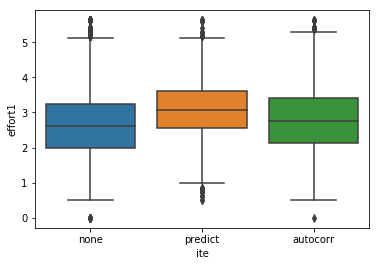

In [20]:
tmp = data.loc[data.hands1 == 'one_hand']
sns.boxplot('ite','effort1',data=tmp)

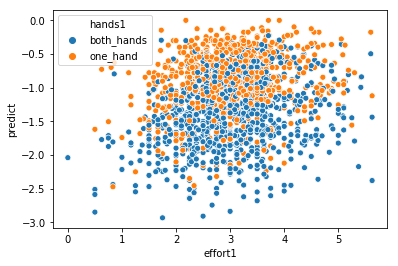

In [21]:
tmp = data.copy()
tmp = tmp.groupby(['word','effort1','effort2','hands1']).ite.value_counts(normalize=True).unstack()['predict']
tmp = tmp.reset_index()
tmp.predict = np.log10(tmp.predict)
sns.scatterplot('effort1','predict',data=tmp,hue='hands1')

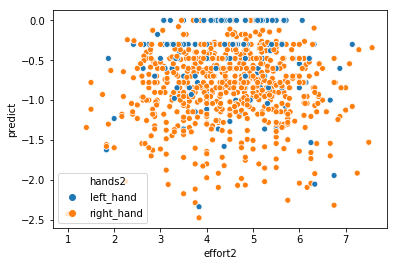

In [22]:
tmp = data.loc[data.hands1 == 'one_hand'].copy()
tmp = tmp.groupby(['word','effort1','effort2','hands2']).ite.value_counts(normalize=True).unstack()['predict']
tmp = tmp.reset_index().set_index('word')
tmp.predict = np.log10(tmp.predict)
sns.scatterplot('effort2','predict',data=tmp,hue='hands2')

### What is the probability of a word being predicted?

#### Multiple regression

In [416]:
qwerty = [
    'qwertyuiop',
    'asdfghjkl',
    'zxcvbnm'
]
tmp = qwerty
for i,line in enumerate(tmp):
    qwerty[i] = list(line)
    
tmp = qwerty
qwerty = {}
# Invert so we have indices
for i,line in enumerate(tmp):
    for j,char in enumerate(line):
        qwerty[char] = [i,j]
qwerty = pd.DataFrame(qwerty).T
# Offset the rows
qwerty.loc[qwerty[0] == 1, 1] += 0.5
qwerty.loc[qwerty[0] == 2, 1] += 1.5

qwerty_dist = spatial.distance_matrix(qwerty,qwerty,p=1)
qwerty_dist = pd.DataFrame(qwerty_dist,index=qwerty.index,columns=qwerty.index)

# Flatten
tmp = qwerty_dist.copy()
qwerty_dist = {}
for i in tmp.index:
    for j in tmp.columns:
        qwerty_dist[i+j] = tmp.loc[i,j]
        
qwerty_comfort_right = (4.5 - qwerty[1]).abs()
qwerty_comfort_left = 9 - qwerty_comfort_right
qwerty_comfort_both = qwerty_comfort_right

def get_effort(x):
    d = 0
    for i,c in enumerate(x[1:]):
        d += qwerty_dist[x[i:i+2]]
    return d

def get_comfort_right_hand(x):
    d = 0
    for c in x.word:
        d += qwerty_comfort_right.loc[c] 
    return d

def get_comfort_left_hand(x):
    d = 0
    for c in x.word:
        d += qwerty_comfort_left.loc[c] 
    return d

def get_comfort_both_hands(x):
    d = 0
    for c in x.word:
        d += qwerty_comfort_both.loc[c]         
    return d

In [508]:
mask = words.ite == 'none'
mask &= words.iki_single > 0
mask &= words.word.str.contains('^[a-z]+$')
mask &= words.word_length < 14
data = words.loc[mask].copy()
data['hands2'] = data.participant_id.map(participants_.hands2)
data['comfort'] = data.apply(get_comfort,axis=1) / data.word_length

data = data.groupby('word').filter(lambda x: x.shape[0] > 40)
data = data.groupby('word')[['freq','word_length','iki_single','comfort']].median()
data['effort'] = data.index.map(get_effort) / data.word_length

tmp = words.loc[(words.word == words.ite_input) | (words.ite == 'none')].copy()
data['probability'] = tmp.groupby('word').ite.value_counts(normalize=True).unstack()['predict']

data = data.dropna()
data.freq = np.log10(data.freq)
data.probability = np.log10(data.probability)

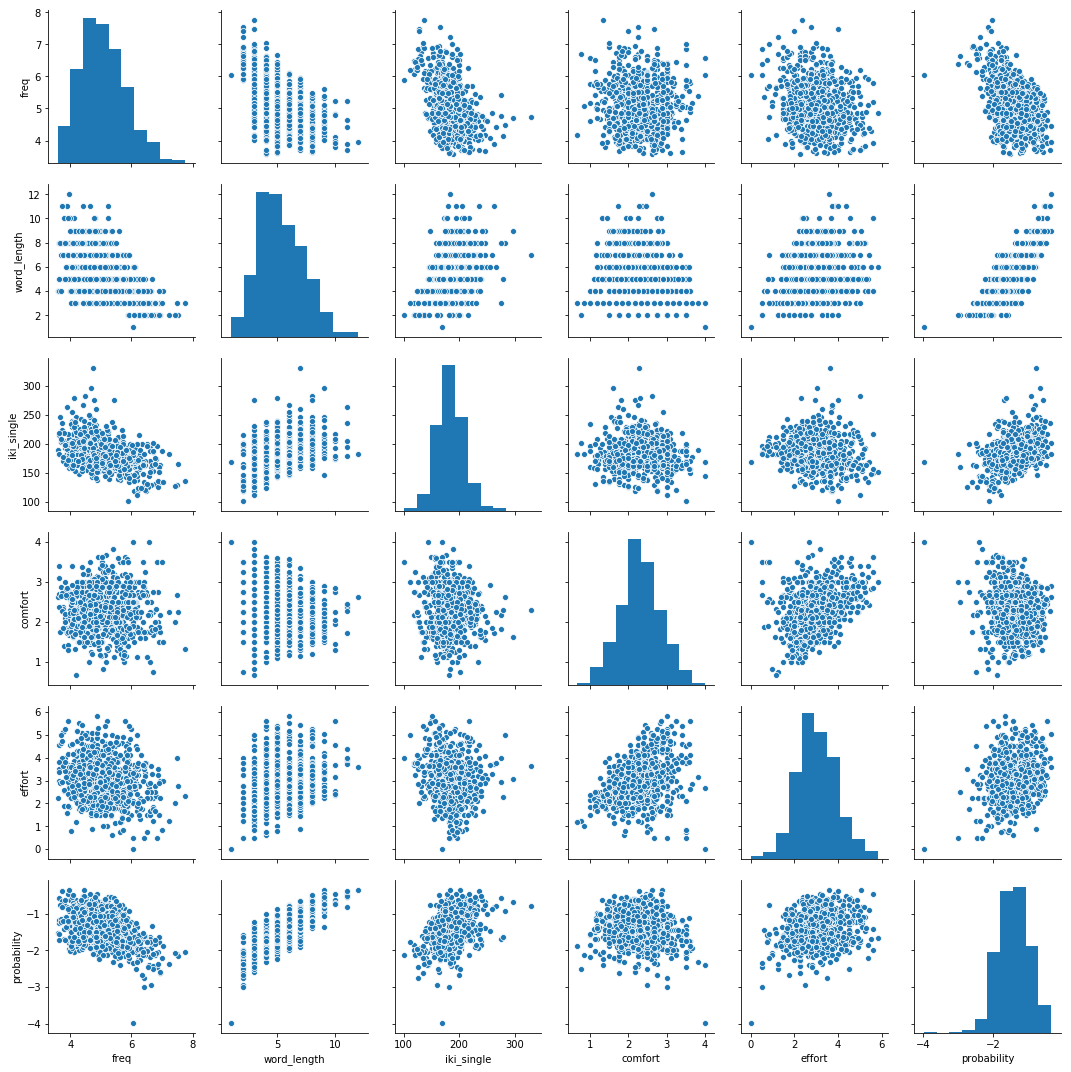

In [509]:
sns.pairplot(data)

In [520]:
X = data[['freq','word_length','iki_single','effort','comfort']].copy()
X = preprocessing.StandardScaler().fit_transform(X)
y = data['probability'].copy()

X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.20,random_state=0)

reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

/Users/itto/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/itto/miniconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.6383167734157191

#### Logistic regression

In [70]:
mask = words.word_length > 1
mask &= words.word.str.contains('^[a-z]+$')
mask &= words.word_length < 14
data = words.loc[mask,['word','freq','word_length','iki_norm','iki_single','ite']].copy()

data = data.loc[data.ite != 'autocorr']

data = data.groupby('word').filter(lambda x: x.shape[0] > 50)
data.iki_norm = data.word.map(data.groupby('word').iki_norm.median())
data.iki_single = data.word.map(data.groupby('word').iki_single.median())

data = data.dropna()
data.freq = np.log10(data.freq)
data = data.set_index('word')

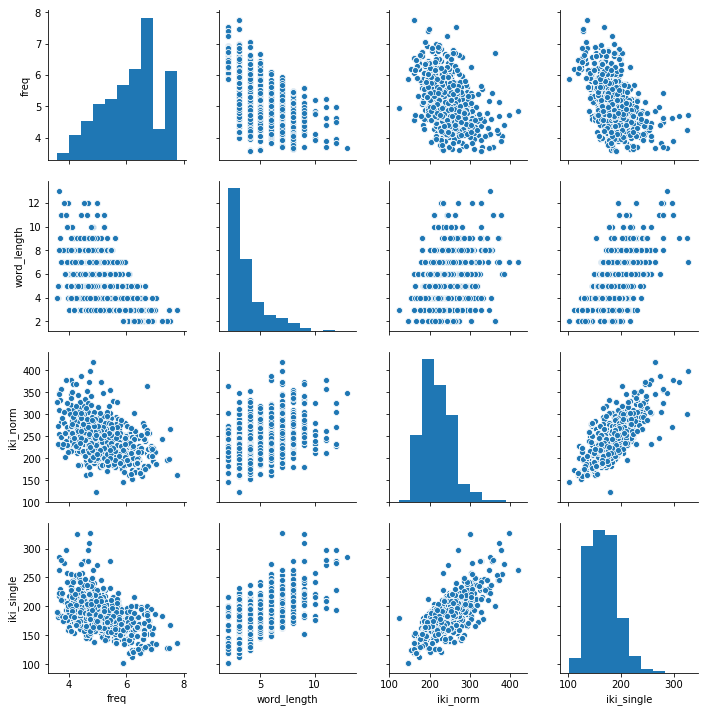

In [71]:
sns.pairplot(data.sample(10000,random_state=0))

In [129]:
X = data.loc[:,data.columns != 'ite'].copy()
X.word_length = X.word_length.astype(float)
X_scaled = preprocessing.StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
y = data['ite'].copy()
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.5,random_state=0)

reg = linear_model.LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=1000, fit_intercept=False)
reg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=1000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [130]:
pd.DataFrame(reg.coef_,columns=X.columns) 

,freq,word_length,iki_norm,iki_single
0,0.055058,0.227926,0.057169,-0.005445


In [135]:
test = X_test.copy()
y_prob = reg.predict_proba(X_test)[:,1]
y_label = reg.predict(X_test)
test['prob'] = y_prob
test['label_pred'] = y_label
test['label_true'] = y_test

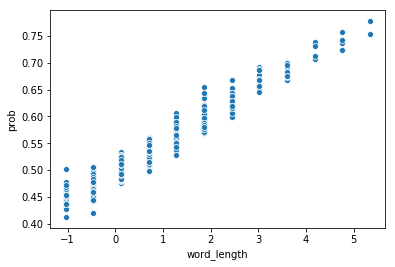

In [137]:
tmp = test.sample(10000)
tmp = tmp.groupby(tmp.index).mean()
sns.scatterplot(tmp.word_length, tmp.prob)

In [108]:
model = sm.MNLogit(y_train,X_train)
model = model.fit(maxiter=1000)

Optimization terminated successfully.
         Current function value: 0.687950
         Iterations 4


In [109]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                    ite   No. Observations:               154759
Model:                        MNLogit   Df Residuals:                   154755
Method:                           MLE   Df Model:                            3
Date:                Wed, 26 Jun 2019   Pseudo R-squ.:                  -3.513
Time:                        20:21:12   Log-Likelihood:            -1.0647e+05
converged:                       True   LL-Null:                       -23593.
                                        LLR p-value:                     1.000
===============================================================================
ite=predict       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
freq            0.0551      0.008      6.858      0.000       0.039       0.071
word_length     0.2279      0.008     28.844      0.000       0.212       0.243
iki_norm        0.0572      0.008      7.145      0.000       0.041       0.073
iki_single     -0.0055      0.009     -0.613      0.540      -0.023       0.012
===============================================================================
"""

In [132]:
y_pred = reg.predict(X_test)
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test,y_pred), index=reg.classes_,columns=reg.classes_)
confusion_matrix

,none,predict
none,100111,49188
predict,1388,4072


### Are certain strategies used for certain words more than for others?

#### Multiple regression

In [272]:
mask = words.ite == 'none'
mask &= words.word_length < 14
participants_1hand = participants_.loc[participants_.hands1 == 'one_hand']
data = words.loc[mask].copy()
data = data.groupby('word').filter(lambda x: x.shape[0] > 15)
data = data.groupby('word')[['freq','word_length','iki_norm']].median()
data = data.loc[data.iki_norm > 0].copy()

tmp = words.loc[(words.word == words.ite_input) | (words.ite == 'none')].copy()
tmp.ite2 = tmp.ite2.fillna('none')
tmp = tmp.groupby('word').ite2.value_counts(normalize=True).reset_index(level=0).rename(
    columns={'ite2':'probability'}
).reset_index()
data = pd.merge(data,tmp,left_index=True, right_on='word').set_index('word')
data = data.loc[~data.ite2.isin(['none'])].copy()

data = data.dropna()
data.freq = np.log10(data.freq)
data.word_length = np.sqrt(data.word_length)
data.probability = np.log10(data.probability)

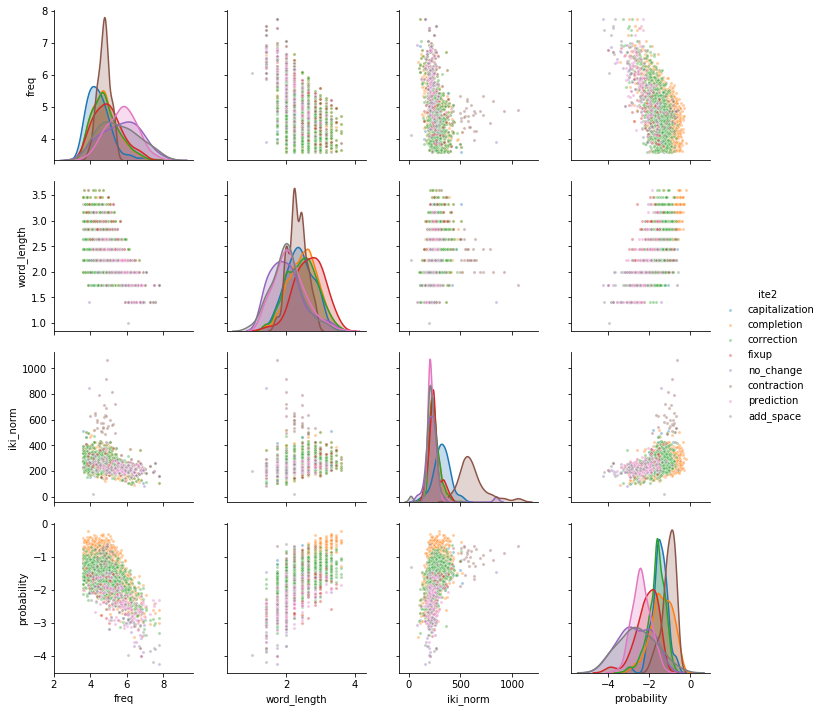

In [275]:
sns.pairplot(data,hue='ite2',plot_kws={'alpha': 0.4, 's':10})

In [276]:
for i,group in data.groupby('ite2'):
    print('***'+i+'***')
    X = group.set_index('ite2').iloc[:,:-1].copy()
    X_scaled = preprocessing.StandardScaler().fit_transform(X)
    X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
    y = group.set_index('ite2').iloc[:,-1].copy()

    X = sm.add_constant(X)
    model = sm.OLS(y,X).fit()
    summary = model.params.to_frame('params')
    summary['P > t'] = model.pvalues
    summary[['0.025','0.975']] = model.conf_int()
    summary.index = X.columns
    print('Observations: {}\n'.format(model.nobs))
    print(summary)
    print('\n\n')

***add_space***
Observations: 41.0

               params         P > t     0.025     0.975
const       -2.563089  2.651668e-29 -2.717889 -2.408289
freq        -0.552097  6.961590e-06 -0.766074 -0.338121
word_length  0.235829  3.205808e-02  0.021340  0.450318
iki_norm    -0.017147  8.260584e-01 -0.174123  0.139830



***capitalization***
Observations: 76.0

               params         P > t     0.025     0.975
const       -1.482751  1.868439e-50 -1.557798 -1.407703
freq        -0.110311  1.271901e-02 -0.196365 -0.024258
word_length  0.074121  8.093434e-02 -0.009350  0.157592
iki_norm     0.060730  1.362982e-01 -0.019627  0.141087



***completion***
Observations: 1381.0

               params          P > t     0.025     0.975
const       -1.387544   0.000000e+00 -1.403039 -1.372048
freq        -0.039044   2.408826e-04 -0.059849 -0.018239
word_length  0.411525  1.716204e-241  0.391875  0.431175
iki_norm     0.057727   3.657586e-11  0.040753  0.074701



***contraction***
Observations

#### Logistic regression

In [11]:
def to_asterix(x):
    if x <= 0.01:
        return '***'
    elif x <= 0.05:
        return '**'
    elif x <= 0.1:
        return '*'
    else:
        return ''

In [12]:
offset_keys = pd.read_csv('./data/key_offset.csv',index_col=0)
def get_offset(x):
    effort = 0
    for c in x:
        if c in offset_keys.index:
            effort += offset_keys.loc[c,'offset_one_thumb']
    return effort

In [82]:
mask = words.word_length > 1
mask &= words.word_length < 14
data = words.loc[mask,['word','ite_input','word_length','freq','ite2','iki_norm']].copy()
data.loc[data.ite_input.notna(),'word'] = data.word
data.drop('ite_input',axis=1,inplace=True)
data.ite2 = data.ite2.fillna('none')
data = data.loc[data.ite2.isin(['completion','correction','contraction','capitalization','prediction','none'])]
data['leadup_length'] = words.loc[mask,'ite_input_prev'].str.len()

data2 = words.loc[words.ite == 'none'].groupby('word').filter(lambda x: x.shape[0] > 20)
data['base_iki_single'] = data.word.map(data2.groupby('word').iki_single.median())
data['covariance'] = data.word.map(get_offset) / data.word_length
data['backspaces'] = data.word.map(data2.groupby('word').n_backspace.mean())
data['is_contraction'] = data.word.str.contains("'").astype(float)
data['is_capitalized'] = data.word.str.contains('[A-Z]').astype(float)

data = data.dropna()
data.freq = np.log10(data.freq)
data.iki_norm = data.iki_norm.apply(np.reciprocal)
data.base_iki_single = data.base_iki_single.apply(np.reciprocal)
data = data.loc[data.covariance < 1].copy()

data = data.set_index('word')

In [83]:
data.ite2.value_counts()

none              34773
completion         8038
correction         4143
prediction          731
capitalization      259
contraction         249
Name: ite2, dtype: int64

/Users/itto/miniconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/itto/miniconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/itto/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


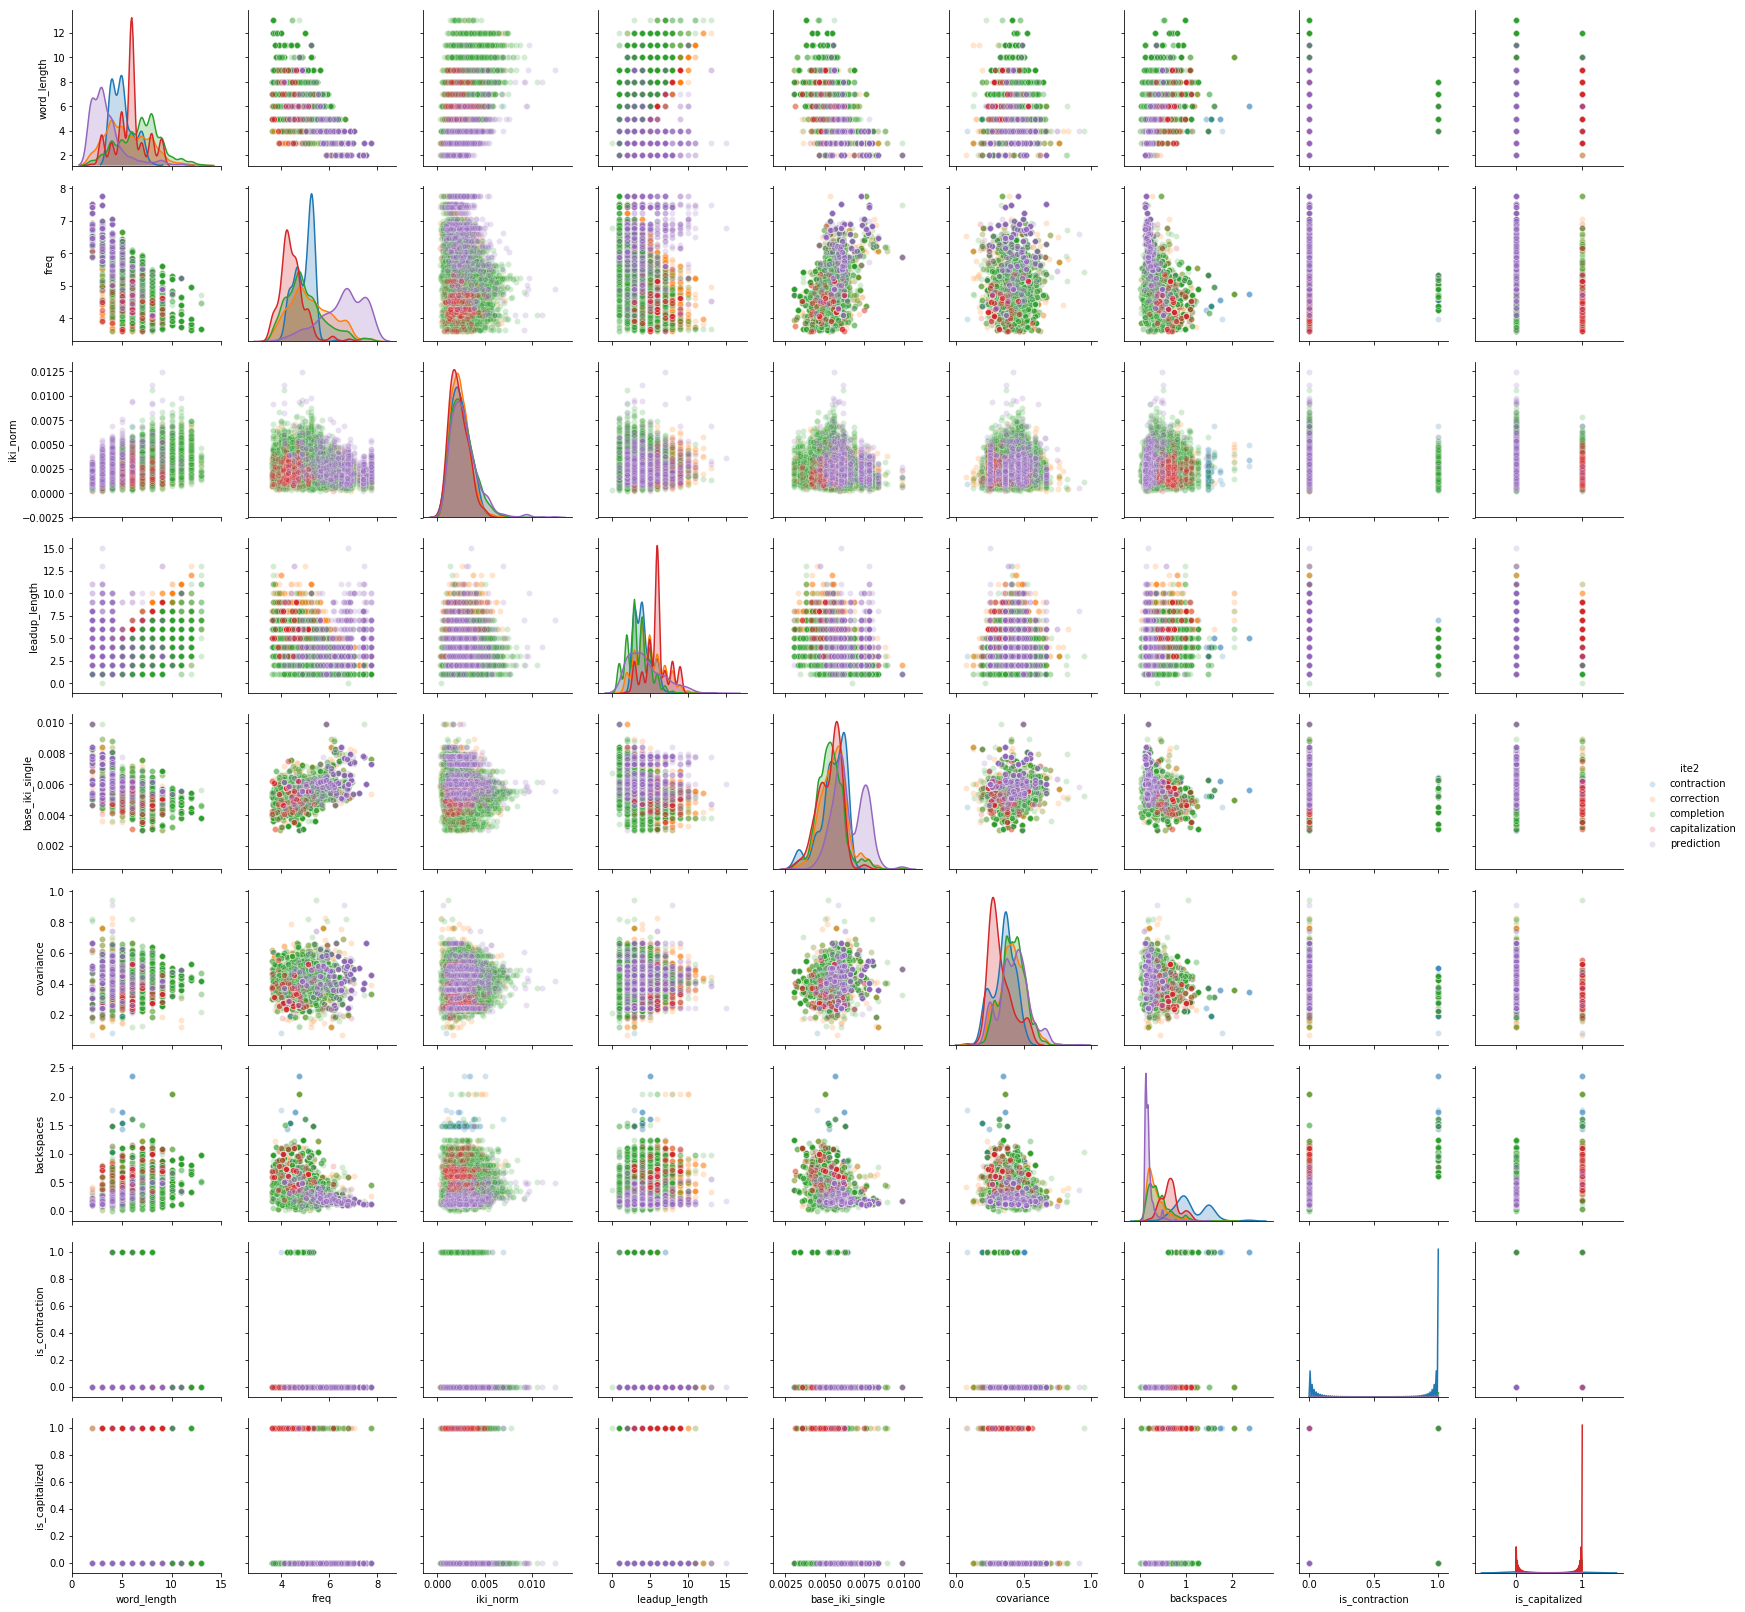

In [82]:
sns.pairplot(data.loc[:,:],hue='ite2',plot_kws={'alpha':0.2})

In [84]:
# Preprocess X
X = data.loc[:,data.columns != 'ite2'].copy()
X.word_length = X.word_length.astype(float)
X_scaled = preprocessing.StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X.is_contraction = data.is_contraction
X.is_capitalized = data.is_capitalized

# Preprocess y
y = data['ite2'].copy()

# Split data
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.1,random_state=1)

# Fit sklearn
reg = linear_model.LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=1000,fit_intercept=True,C=np.inf)
reg.fit(X_train,y_train);

In [85]:
pd.DataFrame(reg.coef_,index=reg.classes_,columns=X.columns).T

,capitalization,completion,contraction,correction,none,prediction
word_length,-1.221916,3.594768,-0.195816,-0.198843,-2.464251,-0.820616
freq,-1.044150,-0.171281,-0.460818,-0.363524,0.181700,0.663062
iki_norm,-1.130508,-1.820619,-1.204658,-1.395989,1.823970,-0.711442
leadup_length,1.270014,-3.212969,0.920739,0.524515,1.702402,0.997145
base_iki_single,0.246300,-0.019272,0.564933,0.087157,-0.162031,0.289914
covariance,-0.048609,0.031212,-0.003472,-0.044232,0.035743,-0.021944
backspaces,-0.188360,-0.121613,-0.129347,0.085406,-0.006559,-0.127369
is_contraction,-16.713100,-0.514043,8.436102,-1.863134,0.680157,-0.681498
is_capitalized,5.869156,-0.138084,0.642727,-0.625771,-0.282278,-1.244417


In [87]:
params = []
X_train = sm.add_constant(X_train)
for i in y_train.sort_values().unique():
    if i == 'none':
        continue
    model = sm.Logit((y_train == i).astype(float),X_train)
    results = model.fit(method='lbfgs',maxiter=1000)
    a = results.params
    for param,val in results.params.iteritems():
        a.loc[param] = str(round(val,2)) + to_asterix(results.pvalues.loc[param])
    params.append(a.to_frame(i))
params = pd.concat(params,axis=1)
params

,capitalization,completion,contraction,correction,prediction
const,-9.52***,-3.57***,-10.57***,-3.01***,-5.02***
word_length,-1.22***,3.59***,-0.2,-0.2***,-0.82***
freq,-1.04***,-0.17***,-0.47**,-0.36***,0.66***
iki_norm,-1.13***,-1.82***,-1.2***,-1.4***,-0.71***
leadup_length,1.27***,-3.21***,0.91***,0.52***,1.0***
base_iki_single,0.24**,-0.02,0.56***,0.09***,0.29***
covariance,-0.05,0.03,-0.0,-0.04**,-0.02
backspaces,-0.19*,-0.12***,-0.13,0.09**,-0.13
is_contraction,-8.94,-0.51***,8.41***,-1.86***,-0.67
is_capitalized,5.86***,-0.14,0.63*,-0.63***,-1.23**


In [62]:
params = []
X_train = sm.add_constant(X_train)
model = sm.Logit((y_train != 'none').astype(float),X_train)
results = model.fit(method='lbfgs',maxiter=1000)
a = results.params
for param,val in results.params.iteritems():
    a.loc[param] = str(round(val,2)) + to_asterix(results.pvalues.loc[param])
params.append(a.to_frame('selection'))
params = pd.concat(params,axis=1)
params

,selection
const,-1.74***
word_length,2.46***
freq,-0.18***
iki_norm,-1.82***
leadup_length,-1.7***
base_iki_single,0.16***
covariance,-0.04**
backspaces,0.01
is_contraction,-0.68***
is_capitalized,0.28***


#### Assessment

In [50]:
test = X_test.copy()
y_prob = reg.predict_proba(X_test)[:,1]
y_label = reg.predict(X_test)
test['prob'] = y_prob
test['label_pred'] = y_label
test['label_true'] = y_test

test.sort_values('prob',ascending=False).sample(10)

,word_length,freq,iki_norm,leadup_length,base_iki_single,covariance,backspaces,is_contraction,is_capitalized,prob,label_pred,label_true
word,,,,,,,,,,,,
nursing,0.957324,-1.744941,0.720580,1.464077,-0.688931,0.501113,0.285282,0.0,0.0,0.002841,none,none
origin,0.493796,-0.999562,-0.818633,0.398910,-1.828233,0.686596,-0.498210,0.0,0.0,0.253783,none,correction
with,-0.433260,1.196909,1.809028,-0.133674,0.767137,0.469272,-0.639745,0.0,0.0,0.000296,none,none
several,0.957324,-0.264987,-0.560494,-0.133674,-0.754325,0.262722,-0.413446,0.0,0.0,0.784132,completion,completion
together,1.420852,-0.152943,-1.049229,2.529243,0.153053,0.303158,-0.716174,0.0,0.0,0.009569,none,none
reports,0.957324,-1.117332,0.279523,1.464077,-1.007866,-1.052464,0.088217,0.0,0.0,0.005650,none,none
any,-0.896787,0.556053,-0.722568,-0.666257,0.202143,0.304193,-0.467964,0.0,0.0,0.034558,none,none
transaction,2.811436,-1.663932,0.330166,0.398910,-1.581005,0.359215,-0.825156,0.0,0.0,0.951630,completion,completion
are,-0.896787,0.831957,-1.302247,-1.198840,-0.737050,-0.117045,-0.662298,0.0,0.0,0.375894,none,correction


In [33]:
y_pred = reg.predict(X_test)
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test,y_pred), index=reg.classes_,columns=reg.classes_)
confusion_matrix

,capitalization,completion,contraction,correction,none,prediction
capitalization,4,0,0,3,25,0
completion,0,675,0,9,96,0
contraction,0,0,4,0,19,0
correction,0,74,1,21,361,0
none,2,66,4,24,3354,0
prediction,0,9,0,0,69,0


In [39]:
reg.score(X_test,y_test)

0.8419087136929461

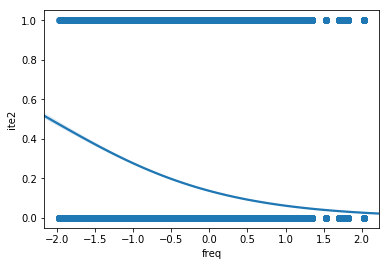

In [58]:
sns.regplot(X_train.freq,y_train == 'completion',logistic=True)

## Performance analysis

In [145]:
mask = words.ite == 'none'
mask &= words.word_length < 5
mask &= words.freq_category == 'very_common'
mask &= words.iki_single.notna()

participants['iki_natural'] = words.loc[mask].groupby('participant_id').iki_single.mean()

In [146]:
participants['n_predict'] = words.loc[words.ite == 'predict'].groupby('participant_id').size()

### Time series analysis

In [210]:
data = log[['participant_id','ts_id','entry_id','iki','key','ite']].copy()

# First iki of each word is undefined
data.loc[data.groupby(['ts_id','entry_id']).head(1).index, 'iki'] = np.nan

# Create artificial timestamp based on the iki
data['iki_rel'] = data.iki / data.participant_id.map(participants.iki_natural)
data['timestamp'] = data.groupby(['ts_id','entry_id']).iki.cumsum()
data['timestamp_rel'] = data.groupby(['ts_id','entry_id']).iki_rel.cumsum()
data.loc[data.groupby(['ts_id','entry_id']).head(1).index, 'timestamp'] = 0
data.loc[data.groupby(['ts_id','entry_id']).head(1).index, 'timestamp_rel'] = 0

# Some processing requires indexing based on ts and entry id's
data.set_index(['ts_id','entry_id'], inplace=True)
data = data.drop(data.loc[~data.key.str.contains('[a-zA-Z]')].index) # Remove entries with backspace, punctuation, numbers
data['ite'] = words.set_index(['ts_id','entry_id']).ite
data['ite2'] = words.set_index(['ts_id','entry_id']).ite2
data['word'] = words.set_index(['ts_id','entry_id']).word
data['word_length'] = words.set_index(['ts_id','entry_id']).word_length
data.reset_index(inplace=True)

# Label each action within an entry
data['action_id'] = data.groupby(['ts_id','entry_id']).cumcount()

# Count the number of actions per entry
data.set_index(['ts_id','entry_id'], inplace=True)
data['n_actions'] = data.groupby(['ts_id','entry_id']).size()
data.reset_index(inplace=True)

In [370]:
words.loc[words.ite2 == 'completion'].word.value_counts().head(10)

tomorrow       164
Thursday       102
expected        90
information     90
questions       79
September       74
against         63
probably        61
available       56
anything        55
Name: word, dtype: int64

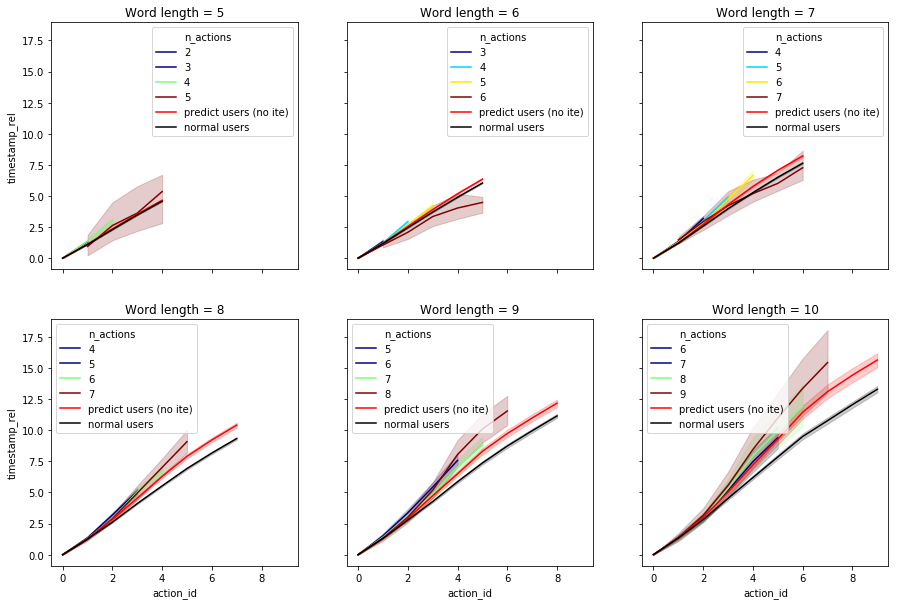

In [226]:
f,ax = plt.subplots(2,3,figsize=(15,10), sharex=True, sharey=True)
ax=ax.flatten()

tmp = data.loc[data.ite != 'autocorr'].copy()
tmp.ite2 = tmp.ite2.fillna('none')
tmp = tmp.loc[tmp.ite2.isin(['none','completion', 'correction'])]
mask = tmp.key.str.len() == 1
tmp = tmp.loc[mask]
for i in range(5,11):
    tmp2 = tmp.loc[tmp.word_length == i].copy()
    mask = ((tmp2.n_actions.isin(range(max(3,i-3),i))) & (tmp2.ite == 'predict'))
    mask |= ((tmp2.n_actions == i) & (tmp2.ite2 == 'none'))
    tmp2 = tmp2.loc[mask]
    
    tmp2 = tmp2.groupby(['ite2','n_actions','action_id']).filter(lambda x: x.shape[0] > 5)
    
    predict_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict) > 5]
    normal_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict)  < 4]
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=predict_users.loc[predict_users.ite == 'predict'],
        hue='n_actions',
        palette='jet',
        ax=ax[i-5]
    )
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=predict_users.loc[predict_users.ite == 'none'],
        ax=ax[i-5],
        color='r',
        label='predict users (no ite)'
    )
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=normal_users.loc[normal_users.ite == 'none'],
        ax=ax[i-5],
        color='k',
        label='normal users'
    )
    ax[i-5].set_title('Word length = {}'.format(i))

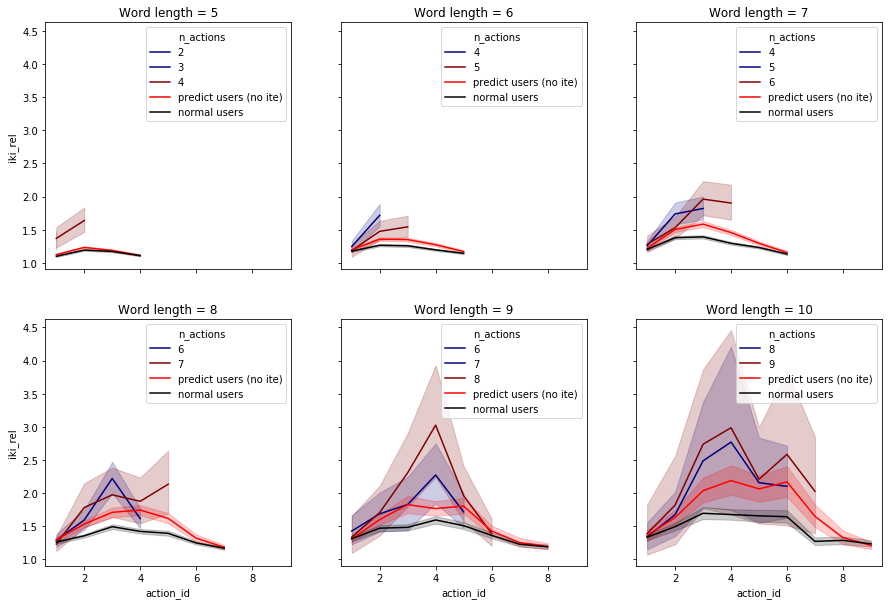

In [221]:
f,ax = plt.subplots(2,3,figsize=(15,10), sharex=True, sharey=True)
ax=ax.flatten()

tmp = data.loc[data.ite != 'autocorr'].copy()
tmp.ite2 = tmp.ite2.fillna('none')
tmp = tmp.loc[tmp.ite2.isin(['none','completion'])]
mask = tmp.key.str.len() == 1
tmp = tmp.loc[mask]
for i in range(5,11):
    tmp2 = tmp.loc[tmp.word_length == i].copy()
    mask = ((tmp2.n_actions.isin(range(max(3,i-2),i))) & (tmp2.ite2 == 'completion'))
    mask |= ((tmp2.n_actions == i) & (tmp2.ite2 == 'none'))
    tmp2 = tmp2.loc[mask]
    
    tmp2 = tmp2.groupby(['ite2','n_actions','action_id']).filter(lambda x: x.shape[0] > 5)
    
    predict_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict) > 5]
    normal_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict)  < 4]
    sns.lineplot(
        'action_id',
        'iki_rel',
        data=predict_users.loc[predict_users.ite2 == 'completion'],
        hue='n_actions',
        palette='jet',
        ax=ax[i-5]
    )
    sns.lineplot(
        'action_id',
        'iki_rel',
        data=predict_users.loc[predict_users.ite2 == 'none'],
        ax=ax[i-5],
        color='r',
        label='predict users (no ite)'
    )
    sns.lineplot(
        'action_id',
        'iki_rel',
        data=normal_users.loc[normal_users.ite2 == 'none'],
        ax=ax[i-5],
        color='k',
        label='normal users'
    )
    ax[i-5].set_title('Word length = {}'.format(i))

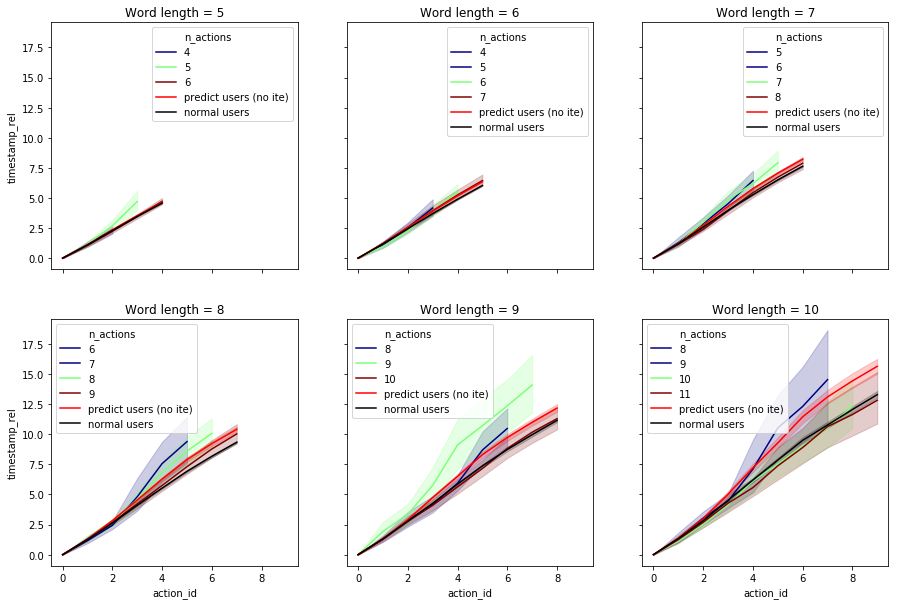

In [225]:
f,ax = plt.subplots(2,3,figsize=(15,10), sharex=True, sharey=True)
ax=ax.flatten()

tmp = data.loc[data.ite != 'autocorr'].copy()
tmp.ite2 = tmp.ite2.fillna('none')
tmp = tmp.loc[tmp.ite2.isin(['none','correction'])]
mask = tmp.key.str.len() == 1
tmp = tmp.loc[mask]
for i in range(5,11):
    tmp2 = tmp.loc[tmp.word_length == i].copy()
    mask = ((tmp2.n_actions.isin(range(max(3,i-1),i+2))) & (tmp2.ite2 == 'correction'))
    mask |= ((tmp2.n_actions == i) & (tmp2.ite2 == 'none'))
    tmp2 = tmp2.loc[mask]
    
    tmp2 = tmp2.groupby(['ite2','n_actions','action_id']).filter(lambda x: x.shape[0] > 5)
    
    predict_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict) > 5]
    normal_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict)  < 4]
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=predict_users.loc[predict_users.ite2 == 'correction'],
        hue='n_actions',
        palette='jet',
        ax=ax[i-5]
    )
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=predict_users.loc[predict_users.ite2 == 'none'],
        ax=ax[i-5],
        color='r',
        label='predict users (no ite)'
    )
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=normal_users.loc[normal_users.ite2 == 'none'],
        ax=ax[i-5],
        color='k',
        label='normal users'
    )
    ax[i-5].set_title('Word length = {}'.format(i))

## Do certain participants use prediction more than others?

In [542]:
data = words.groupby('ite').participant_id.value_counts(normalize=True, ascending=True).reset_index(1, drop=True)
data = data.groupby(data.index).cumsum()
data = data.reset_index()
data = data.reset_index()
data = data.rename(columns={'index':'participants','participant_id':'cumulative_share'})
data.participants = data.groupby('ite').participants.apply(lambda x: (x - x.min())/(x.max() - x.min()))

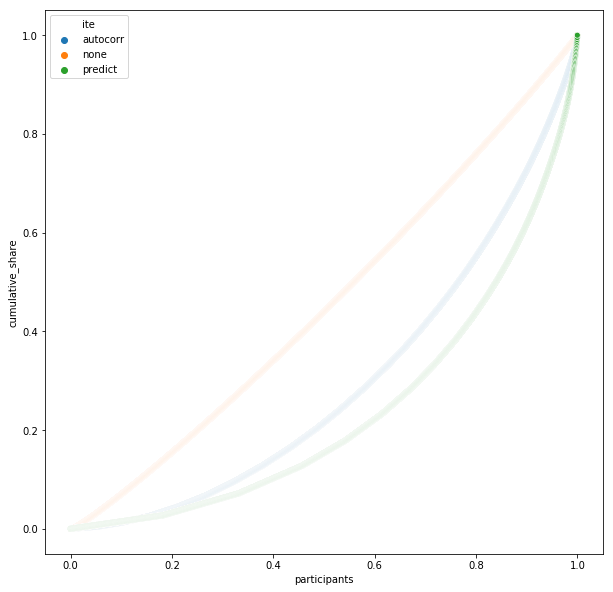

In [543]:
f,ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(data.participants, data.cumulative_share, hue = data.ite, ax=ax)

In [540]:
data = words.groupby('ite2').participant_id.value_counts(normalize=True, ascending=True).reset_index(1, drop=True)
data = data.groupby(data.index).cumsum()
data = data.reset_index()
data = data.reset_index()
data = data.rename(columns={'index':'participants','participant_id':'cumulative_share'})
data.participants = data.groupby('ite2').participants.apply(lambda x: (x - x.min())/(x.max() - x.min()))

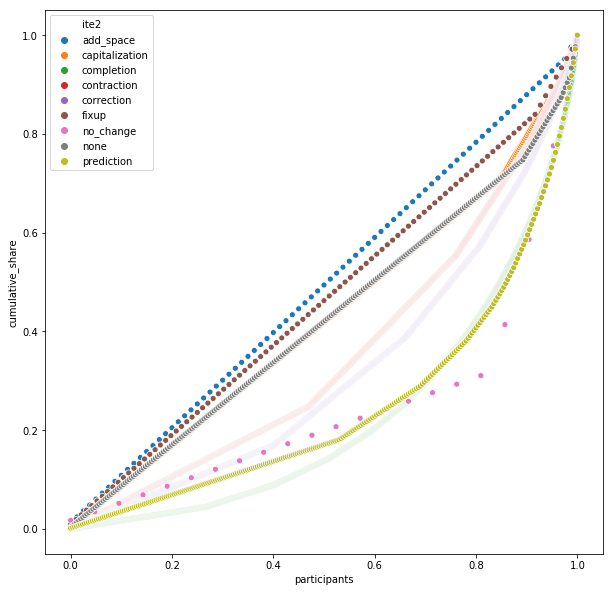

In [541]:
f,ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(data.participants, data.cumulative_share,hue=data.ite2, ax=ax)

In [58]:
data = participants_.loc[
    participants.n_predict > 2,
    ['AGE','GENDER','TIME_SPENT_TYPING','TYPE_ENGLISH','hands1','hands2']
].copy()
data = data.loc[data.AGE < 56].copy()

data['predict'] = participants_ite.predict
data.predict = stats.boxcox(data.predict)[0]

data['completion'] = participants_ite2.completion
data['correction'] = participants_ite2.correction

# Characters per second based on words where no ITE was used
data['natural_speed'] = words.loc[(words.ite == 'none') & (words.word_length < 5)].groupby('participant_id').iki_single.mean()
data.natural_speed = np.reciprocal(data.natural_speed) * 1000

data['age_binned'] = pd.cut(data.AGE,[0,10,15,19,25,35,55])

data['experience_binned'] = pd.cut(data.TIME_SPENT_TYPING,6)

data['native_english'] = participants_.NATIVE_LANGUAGE == 'en'

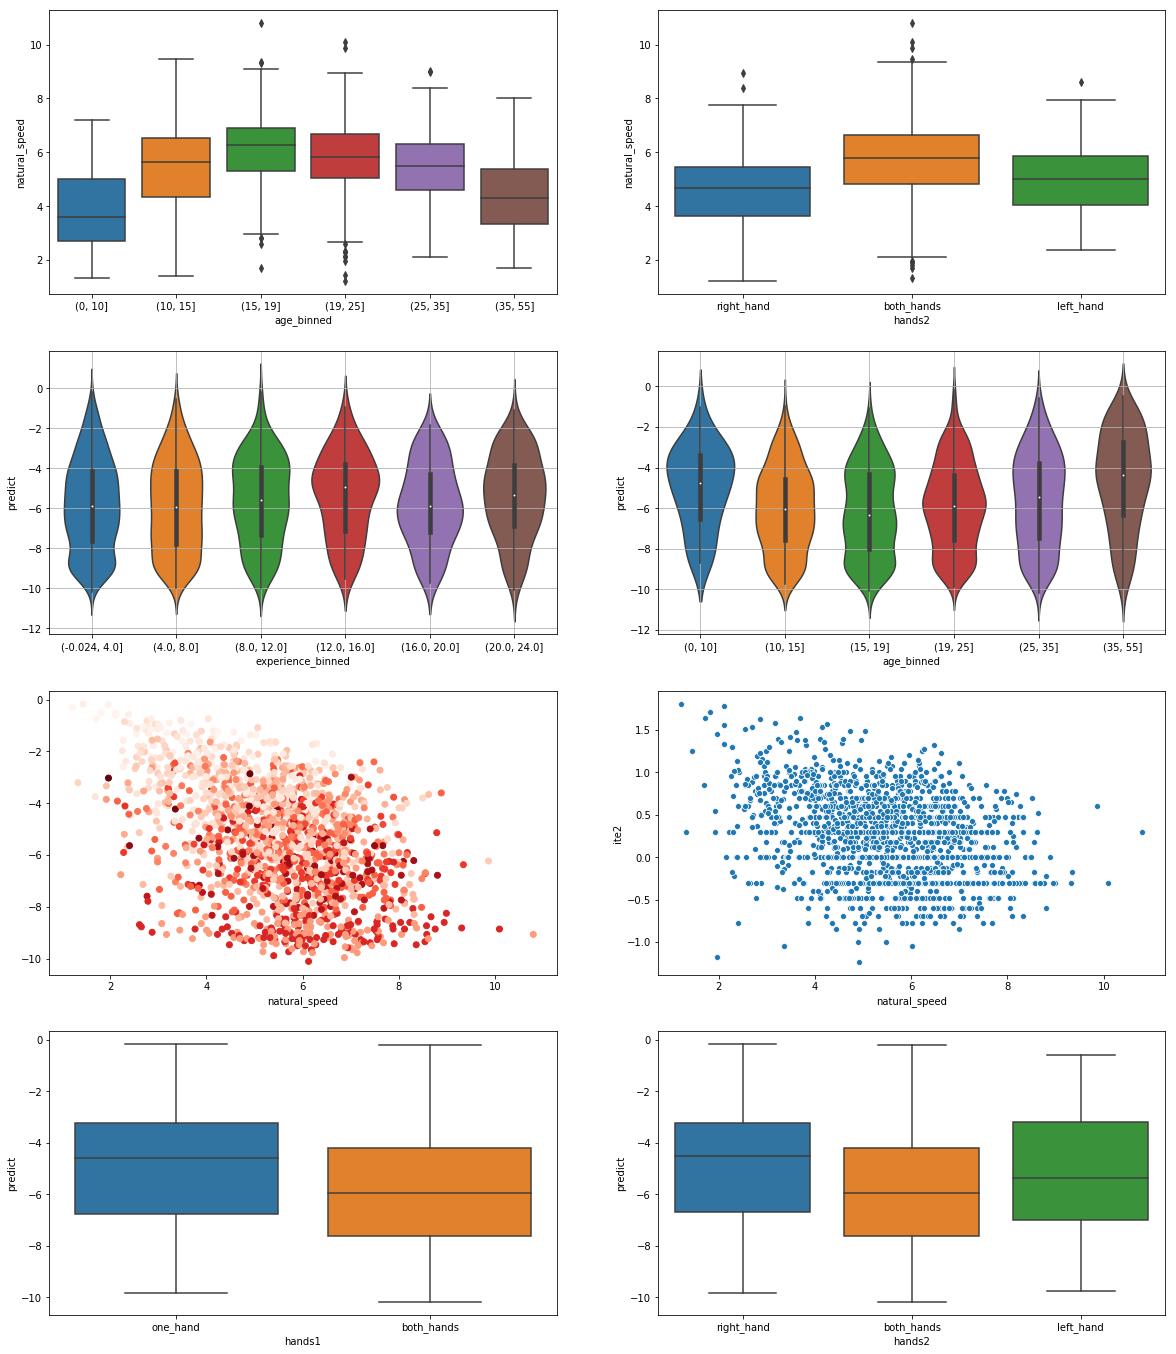

In [59]:
f,ax = plt.subplots(4,2,figsize=(20,24))
ax = ax.flatten()

sns.boxplot(data.age_binned, data.natural_speed,ax=ax[0])

sns.boxplot(data.hands2, data.natural_speed, ax=ax[1])

sns.violinplot(data.experience_binned, data.predict, ax=ax[2])
ax[2].grid()

sns.violinplot(data.age_binned, data.predict, ax=ax[3])
ax[3].grid()

data2 = data.loc[(data.completion > 0) & (data.correction > 0)].copy()
im = ax[4].scatter(data2.natural_speed, data2.predict, c=data2.correction, cmap='Reds')
ax[4].set_xlabel('natural_speed')
# f.colorbar(im,ax=ax[4])

data2 = data.loc[(data.completion > 0) & (data.correction > 0)].copy()
data2['ite2'] = np.log10(data2.completion/data2.correction)
sns.scatterplot(data2.natural_speed, data2.ite2, ax=ax[5])

sns.boxplot(data.hands1,data.predict,ax=ax[6])
sns.boxplot(data.hands2,data.predict,ax=ax[7])

In [ ]:
X_continuous = data[['AGE','natural_speed']].copy()
ss = preprocessing.StandardScaler()
X_continuous = pd.DataFrame(ss.fit_transform(X_continuous),columns=X_continuous.columns,index=X_continuous.index)

X_categorical = data[['hands1']].copy()
X_categorical.hands1 = pd.get_dummies(X_categorical.hands1)['both_hands']

X = pd.merge(X_continuous, X_categorical,left_index=True,right_index=True)
y = data['predict']

reg = linear_model.LinearRegression()
reg.fit(X,y)

In [ ]:
reg.coef_

In [ ]:
reg.score(X,y)

## Word analysis

### Categorical

In [ ]:
data = words.loc[words.ite == 'predict']
data = data.loc[data.ite_lev_ratio <= 1]

# Discretize
features_words = pd.DataFrame()
features_words['length'] = pd.cut(data.ite_input_len,[0,3,7,20],labels=['short','medium','long'])
features_words['freq'] = data.freq_category
features_words['ratio'] = pd.cut(data.ite_lev_ratio,[0,0.25,0.5,0.75,0.99,1])

# Other categoricals
features_words['ite2'] = data.ite2

# To dummy
features_words = pd.get_dummies(features_words)
features_words = features_words.astype('bool')
features_words = features_words.sample(1500)

# No standardization necessary
features_words_ss = features_words.copy()

In [ ]:
features_words_embedded = umap.UMAP(90,metric='jaccard',min_dist=0.01).fit_transform(features_words_ss)
features_words_embedded = pd.DataFrame(features_words_embedded,columns=['x','y'])

In [ ]:
f,ax = plt.subplots(5,4,figsize=(15,18))
ax = ax.flatten()

f.tight_layout(w_pad=3,h_pad=3)

sections = features_words_ss.columns

for i,section in enumerate(sections[:]):
    ax[i].scatter(
        features_words_embedded.x,
        features_words_embedded.y,
        c=features_words_ss[section],
        s=1,
    )
    ax[i].set_title(section)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [ ]:
f.savefig('/Users/itto/Downloads/umap_categorical_80_jaccard_001.svg',dpi=300)

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=40)
clusterer.fit(features_words_embedded)

features_words_embedded['label'] = clusterer.labels_
features_words_embedded['prob'] = clusterer.probabilities_

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

im = ax1.scatter(
    features_words_embedded.x,
    features_words_embedded.y,
    c=features_words_embedded.label,
    s = 5
)
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
f.colorbar(im,ax=ax1)

im = ax2.scatter(
    features_words_embedded.x,
    features_words_embedded.y,
    c=features_words_embedded.prob,
    cmap='copper',
    s = 5
)
ax2.set_aspect('equal')
ax2.set_xticks([])
ax2.set_yticks([])
f.colorbar(im,ax=ax2)

f.tight_layout()

In [ ]:
f.savefig('/Users/itto/Downloads/hdbscan_categorical_80_jaccard_001.svg',dpi=300)

In [ ]:
results = pd.DataFrame(index=features_words_ss.index)
results['label'] = features_words_embedded.label.values
results.label.value_counts()

In [ ]:
f,ax = plt.subplots(2,2,figsize=(15,8))
f.tight_layout(w_pad=5,h_pad=5)
ax = ax.flatten()

data = words.reindex(results.index).copy()

# 1
sns.stripplot(x=results.label,y=data.ite_input_len,ax=ax[0])
# 2
g = sns.boxplot(x=results.label,y=data.freq,ax=ax[1])
g.set_yscale('log')
# 3
data.groupby(results.label).freq_category.value_counts(normalize=True).unstack().plot.bar(stacked=True,ax=ax[2])
# 4
g = sns.stripplot(x=results.label,y=data.ite_lev_ratio,ax=ax[3])

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

sns.boxplot(x=results.label,y=data.iki_norm,ax=ax1)
ax1.set_ylim(0,800)

sns.boxplot(x=results.label,y=data.ite_iki,ax=ax2)
ax2.set_ylim(300,2000)

f.tight_layout()

In [ ]:
log.head(20)

### ITE2

In [ ]:
f,ax = plt.subplots(1,1,figsize=(5,5))
ax1 = ax
ax1.set_title('3 Prediction Subtypes',fontsize=18)

data = words.loc[words.ite2.isin(['completion','correction','prediction'])]
data.ite2.value_counts().plot.pie(ax=ax1,autopct='%.1f')
ax1.set_aspect('equal')
ax1.set_ylabel('')

In [ ]:
f.savefig('./figures/prediction_subtypes_pie.png',dpi=300)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,5))
ax.grid(True)
ax.set_title('Time per letter leading up to prediction event',fontsize=18)
data = words.loc[words.ite.isin(['none','predict'])].copy()
data.ite2.fillna('none',inplace=True)
data = data.loc[data.ite2.isin(['none','completion','correction'])]
data = data.loc[data.iki_single < 800]
sns.violinplot(data.ite2,data.iki_single,showfliers=False,ax=ax)
ax.set_yticks(np.arange(0,900,100))

In [ ]:
f.savefig('./figures/iki_single_violin.png',dpi=400)

In [ ]:
data = participants_ite2.loc[participants.n_predict > 10]
sns.scatterplot(participants_ite2.completion,participants_ite2.correction)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,6))
data = participants_ite2.loc[participants.n_predict > 5]
data = data.completion
data = data.sort_values()
sns.scatterplot(data=data.values, ax=ax)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,5))
ax1 = ax

f.tight_layout(w_pad=5,h_pad=5)


ax1.set_title('')
data = words.copy()
# data = data.loc[data.ite2.isin(['completion','correction'])]
data.ite2.fillna('none',inplace=True)
data.groupby(['ite','ite2']).freq_category.value_counts(normalize=True).unstack().T.plot.bar(ax=ax1)

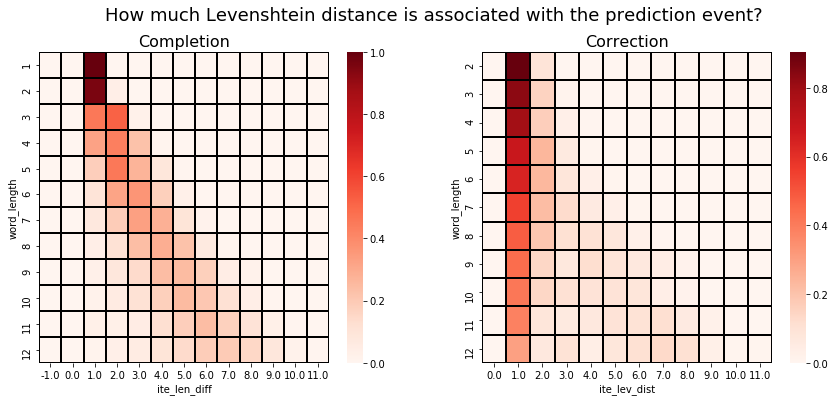

In [68]:
mask = (words.ite_input == words.word) & (words.ite_lev_dist <= words.ite_input_len)

data = words.loc[(words.ite2 == 'completion') & mask]
data = data.loc[data.word_length < 13]
section1 = data.word_length
section2 = data.ite_len_diff
matrix1 = data.groupby([section1,section2]).size().unstack().fillna(0)
# Normalize rows
matrix1 = matrix1.div(matrix1.sum(axis=1),axis=0)

data = words.loc[(words.ite2 == 'correction') & mask]
data = data.loc[data.word_length < 13]
section1 = data.word_length
section2 = data.ite_lev_dist
matrix2 = data.groupby([section1,section2]).size().unstack().fillna(0)
# Normalize rows
matrix2 = matrix2.div(matrix2.sum(axis=1),axis=0)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(13,6))
f.tight_layout(pad=5)
f.suptitle('How much Levenshtein distance is associated with the prediction event?',fontsize=18)

ax1.set_title('Completion',fontsize=16)
sns.heatmap(matrix1,ax=ax1,cmap='Reds',linewidths=1,linecolor='k')

ax2.set_title('Correction',fontsize=16)
sns.heatmap(matrix2,ax=ax2,cmap='Reds',linewidths=1,linecolor='k')

In [77]:
words.strategic.value_counts(normalize=True)

none           0.934070
add            0.029179
other          0.017774
remove         0.012340
same_prefix    0.006638
Name: strategic, dtype: float64

In [78]:
2.92+1.23+0.0066

4.1566

In [79]:
words.loc[(words.ite == 'predict') & (words.strategic == 'other')].sample(10)

,participant_id,ts_id,entry_id,word,word_length,iki_norm,iki_single,ite,ite2,ite_input,...,ite_input_len,ite_input_prev,ite_lev_dist,ite_len_diff,ite_iki,n_backspace,type,freq,freq_category,strategic
82689,69637,263066,7,underestimating,15,488.333333,395.100000,predict,correction,underestimated,...,14.0,underexti,6.0,5.0,1176.0,3.0,generic,NaN,uncommon,other
43467,36718,133936,6,25,2,1933.500000,NaN,predict,none,didn't,...,6.0,wend,6.0,5.0,605.0,7.0,generic,NaN,uncommon,other
411874,226762,1422872,8,Sanaa,5,1085.800000,256.200000,predict,contraction,Sana'a,...,6.0,Sanaa,1.0,1.0,658.0,5.0,proper,NaN,uncommon,other
343283,188875,1146400,8,nation's,8,1204.250000,608.500000,predict,correction,nations,...,7.0,mations,1.0,0.0,1463.0,2.0,contraction,NaN,uncommon,other
464382,251501,1620322,5,or,2,2651.500000,399.000000,predict,correction,it,...,2.0,ot,1.0,0.0,531.0,3.0,generic,4228287.0,very_common,other
429585,235464,1490801,0,Also,4,1266.500000,389.800000,predict,correction,Malls,...,5.0,Alos,2.0,1.0,1023.0,6.0,generic,608042.0,very_common,other
433744,237371,1506489,7,I'm,3,2076.666667,503.000000,predict,contraction,i'm,...,3.0,im,1.0,1.0,812.0,5.0,contraction,NaN,uncommon,other
183388,112820,582549,3,silly,5,752.200000,186.857143,predict,correction,will,...,4.0,aill,1.0,0.0,920.0,5.0,generic,23553.6,common,other
473032,255797,1656584,2,offences,8,712.875000,208.888889,predict,correction,offenses,...,8.0,offences,1.0,0.0,1288.0,4.0,generic,NaN,uncommon,other
151262,97280,463364,2,three,5,684.600000,210.200000,predict,correction,thee,...,4.0,tgee,1.0,0.0,956.0,3.0,generic,502146.0,very_common,other


In [69]:
words.loc[(words.ite2 == 'completion') & (words.ite_len_diff < 1)]

,participant_id,ts_id,entry_id,word,word_length,iki_norm,iki_single,ite,ite2,ite_input,...,ite_input_len,ite_input_prev,ite_lev_dist,ite_len_diff,ite_iki,n_backspace,type,freq,freq_category,strategic
76691,61735,234616,1,assistant,9,462.000000,179.142857,autocorr,completion,assistant,...,9.0,assistand,1.0,0.0,78.0,7.0,generic,10119.40,common,NaN
82154,69292,261676,3,indicates,9,525.333333,206.000000,autocorr,completion,indicates,...,9.0,indicatea,1.0,0.0,231.0,2.0,generic,6896.32,common,NaN
158448,100853,489823,2,importance,10,909.500000,573.166667,autocorr,completion,importance,...,10.0,importannce,1.0,-1.0,134.0,3.0,generic,70066.80,common,NaN
229101,134815,745606,3,tickets,7,771.142857,211.888889,autocorr,completion,tickets,...,7.0,ticketa,1.0,0.0,157.0,9.0,generic,5975.43,common,NaN
260980,149633,855414,3,comforted,9,1080.666667,456.000000,autocorr,completion,comforted,...,9.0,comfirmed,2.0,0.0,141.0,9.0,generic,NaN,uncommon,NaN
274678,156030,902665,2,participation,13,755.384615,222.714286,autocorr,completion,participation,...,13.0,particupation,1.0,0.0,122.0,12.0,generic,4651.87,common,NaN
378520,205599,1270679,9,disappointing,13,600.230769,153.700000,autocorr,completion,disappointing,...,13.0,disappojnting,1.0,0.0,86.0,8.0,generic,NaN,uncommon,NaN
416398,229035,1441209,4,distributed,11,1642.181818,337.300000,autocorr,completion,distributed,...,11.0,distrubuted,1.0,0.0,330.0,15.0,generic,55431.60,common,NaN
427353,234224,1481501,4,responsibility,14,703.571429,355.833333,autocorr,completion,responsibility,...,14.0,responsivulity,2.0,0.0,205.0,8.0,generic,24110.60,common,NaN
432403,237008,1502794,1,Tuesday's,9,1436.444444,380.250000,autocorr,completion,Tuesday's,...,9.0,Tuesdayhe,2.0,0.0,212.0,9.0,contraction,NaN,uncommon,NaN


In [73]:
log.loc[(log.ts_id == 489823) & (log.entry_id == 2)].head(50)

,ts_id,entry_id,key,text_field,lev_dist,participant_id,len_diff,iki,text_field_prev,is_rep,ite,is_forward,iki_norm,tmp,ite2
928074,489823,2,i,Hence the i,1,100853,1,903.0,Hence the,False,none,True,903.000000,False,NaN
928075,489823,2,m,Hence the im,1,100853,1,545.0,Hence the i,False,none,True,545.000000,False,NaN
928076,489823,2,p,Hence the imp,1,100853,1,1116.0,Hence the im,False,none,True,1116.000000,False,NaN
928077,489823,2,o,Hence the impo,1,100853,1,402.0,Hence the imp,False,none,True,402.000000,False,NaN
928078,489823,2,important,Hence the important,5,100853,5,1180.0,Hence the impo,False,predict,True,131.111111,False,completion
928080,489823,2,_,Hence the important,1,100853,-1,827.0,Hence the important,False,none,True,827.000000,False,NaN
928081,489823,2,_,Hence the importan,1,100853,-1,315.0,Hence the important,False,none,True,315.000000,False,NaN
928082,489823,2,_,Hence the importa,1,100853,-1,188.0,Hence the importan,False,none,True,188.000000,False,NaN
928083,489823,2,n,Hence the importan,1,100853,1,2109.0,Hence the importa,False,none,True,2109.000000,False,NaN
928084,489823,2,n,Hence the importann,1,100853,1,522.0,Hence the importan,False,none,True,522.000000,False,NaN


In [ ]:
f.savefig('./figures/ld_heatmap.png',dpi=400)

In [560]:
words.ite2.value_counts(normalize=True)

completion        0.520827
correction        0.239016
contraction       0.168820
prediction        0.028656
capitalization    0.021853
none              0.011440
fixup             0.004029
add_space         0.003154
no_change         0.002204
Name: ite2, dtype: float64

In [548]:
data = words.copy()
data.ite2 = words.ite2.fillna('none')
data.groupby(data.word.str.contains("'")).ite2.value_counts(normalize=True)

word   ite2          
False  none              0.958170
       completion        0.026154
       correction        0.012198
       prediction        0.001481
       capitalization    0.001130
       contraction       0.000398
       fixup             0.000197
       add_space         0.000164
       no_change         0.000108
True   none              0.569918
       contraction       0.380065
       completion        0.039530
       correction        0.009233
       fixup             0.000538
       no_change         0.000269
       prediction        0.000269
       capitalization    0.000179
Name: ite2, dtype: float64

In [612]:
data = words.copy()
data.groupby(data.word.str.contains("'")).ite2.value_counts(normalize=True)

word   ite2          
False  completion        0.616826
       correction        0.287694
       prediction        0.034927
       capitalization    0.026649
       none              0.013441
       contraction       0.009394
       fixup             0.004651
       add_space         0.003860
       no_change         0.002558
True   contraction       0.881497
       completion        0.091684
       correction        0.021414
       none              0.002495
       fixup             0.001247
       no_change         0.000624
       prediction        0.000624
       capitalization    0.000416
Name: ite2, dtype: float64

In [561]:
data = words.copy()
# data.ite2 = words.ite2.fillna('none')
data.groupby(data.word.str.contains("[A-Z]")).ite2.value_counts(normalize=True)

word   ite2          
False  completion        0.568298
       correction        0.260343
       contraction       0.114455
       prediction        0.034253
       none              0.011880
       fixup             0.004207
       add_space         0.003791
       no_change         0.002126
       capitalization    0.000647
True   contraction       0.420175
       completion        0.301346
       correction        0.140415
       capitalization    0.119897
       none              0.009404
       fixup             0.003206
       prediction        0.002778
       no_change         0.002565
       add_space         0.000214
Name: ite2, dtype: float64

## Grouping participants

### Motivation

We saw how there are specific manners and words for which prediction is used. We saw for example a global trend towards using prediction on longer words, and using it for completion instead of correction. But those were global trends. There is variation between users. 

For example, let's look at word length, where the average user is more likely to use prediction on longer words

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,6))

f.tight_layout(pad = 5)
f.suptitle('Probability of a word being predicted',fontsize=18)

user = 221938
# In the case of ITE, the input is equal to the final word
mask = (words.ite_input == words.word) | (words.ite == 'none')
# Very long words don't occur enough times to make a conclusion
data = words.loc[(words.word_length < 13) & mask].copy()
data.loc[data.participant_id != user,'participant_id'] = 'Average user'
data.loc[data.participant_id == user,'participant_id'] = 'User ' + str(user)
data = data.groupby(['word_length','participant_id']).ite.value_counts(normalize=True).unstack().reset_index().fillna(0)
w = participants_ite.loc[user,'predict'] / participants_ite.predict.mean()
data.loc[data.participant_id == 'User '+str(user),'predict'] /= w
sns.barplot('word_length','predict',hue='participant_id',data=data,ax=ax)
ax.set_xlabel('Word length')
ax.set_ylabel('')
ax.set_yticks([]);

In [ ]:
f.savefig('./figures/length_predict_probability_compare.png',dpi=400)

As another example, let's look at the prediction subtype, where the average user is more likely to use prediction for completion rather than correction.

In [ ]:
f,ax = plt.subplots(1,2,figsize=(14,7))
f.suptitle('3 Prediction Subtypes',fontsize=18)
f.tight_layout(pad=8)
ax1,ax2 = ax.flatten()
data = words.loc[words.ite2.isin(['completion','prediction','correction'])]
data.ite2.value_counts().plot.pie(ax=ax1)
data.loc[data.participant_id == 253075].ite2.value_counts().plot.pie(ax=ax2,colors=['C1','C0'])
ax1.set_title('Average User',fontsize=14)
ax1.set_aspect('equal')
ax1.set_ylabel('')
ax2.set_title('User 253075',fontsize=14)
ax2.set_aspect('equal')
ax2.set_ylabel('')

In [ ]:
f.savefig('./figures/prediction_subtypes_pie_compare.png',dpi=400)

### Grouping participants

In [ ]:
features = pd.DataFrame()
mask = participants.n_predict > 5

features['usage'] = participants_ite.loc[mask].predict
# features.usage = stats.boxcox(features.usage)[0]

features = pd.concat([features,participants_ite2.loc[mask,['completion']]],axis=1)

freq = participants_freq_numeral_relative.loc[mask]
features['freq'] = freq

features['len'] = participants_len.loc[mask]
features['len_pref'] = participants_len_pref.loc[mask]

features['lev_ratio'] = participants_lev_ratio.loc[mask]
features = features.loc[features.lev_ratio < 1]

features['lev_ratio_pref'] = participants_lev_ratio_pref.loc[mask]

features['speed'] = participants_speed.loc[mask]

features['fingers'] = participants_fingers.loc[mask]

#### Correlation

In [ ]:
sns.pairplot(features)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(9,7))
sns.heatmap(features.corr().abs(),annot=True,cmap='Reds')

#### Clustering

In [ ]:
scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler()

In [ ]:
features_ss = scaler.fit_transform(features)
features_ss = pd.DataFrame(features_ss,columns=features.columns)

In [ ]:
n = 60
m = 'cosine'
lr = .1
d = .001
features_embedded = umap.UMAP(
    n,
    metric=m,
    learning_rate=lr,
    min_dist=d).fit_transform(features_ss)

In [ ]:
f,ax = plt.subplots(3,3,figsize=(15,15),sharex=True,sharey=True)
ax = ax.flatten()

f.tight_layout(w_pad=2,h_pad=5,rect=[0, 0.03, 1, 0.92])

f.suptitle('n = {}, m = {}, lr = {}, d = {}'.format(n,m,lr,d),fontsize=20)

sections = features.columns

for i,section in enumerate(sections):
    im = ax[i].scatter(features_embedded[:,0],features_embedded[:,1],c=features_ss[section],cmap='Reds',s=2)
    ax[i].set_title(section)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    f.colorbar(im, ax=ax[i])

In [ ]:
f,ax = plt.subplots(1,1,figsize=(5,5),sharex=True,sharey=True)
ax.scatter(features_embedded[:,0],features_embedded[:,1],s=1)
ax.set_xticklabels([])
ax.set_yticklabels([])


In [ ]:
f.savefig('./figures/cluster_participants_continuous.png',dpi=300)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(5,5),sharex=True,sharey=True)
ax.scatter(features_embedded[:,0],features_embedded[:,1],s=1)
ax.set_xticklabels([])
ax.set_yticklabels([])


In [ ]:
f.savefig('./figures/cluster_participants_mixed.png',dpi=300)

In [ ]:
from scipy import spatial

In [ ]:
qwerty = [
    'qwertyuiop',
    'asdfghjkl',
    'zxcvbnm'
]
tmp = qwerty
for i,line in enumerate(tmp):
    qwerty[i] = list(line)

tmp = qwerty
qwerty = {}
# Invert so we have indices
for i,line in enumerate(tmp):
    for j,char in enumerate(line):
        qwerty[char] = [i,j]
qwerty = pd.DataFrame(qwerty).T
# Offset the rows
qwerty.loc[qwerty[0] == 1, 1] += 0.5
qwerty.loc[qwerty[0] == 2, 1] += 1.5

qwerty_dist = spatial.distance_matrix(qwerty,qwerty,p=1)
qwerty_dist = pd.DataFrame(qwerty_dist,index=qwerty.index,columns=qwerty.index)

# Flatten
tmp = qwerty_dist.copy()
qwerty_dist = {}
for i in tmp.index:
    for j in tmp.columns:
        qwerty_dist[i+j] = tmp.loc[i,j]

In [ ]:
from scipy import spatial

In [ ]:
mask = (log.key.str.len() == 1) & (log.key.shift(1).str.len() == 1)
mask &= (log.key.str.contains('[a-z]')) & (log.key.shift(1).str.contains('[a-z]'))

times = log.loc[mask,['text_field','key','iki','participant_id']]


participants = pd.read_csv('./data/participants.csv',sep='\t')
mask = participants.FINGERS.str.split(';').str[0] != 'both_hands'
times['hands'] = times.participant_id.map(participants.set_index('PARTICIPANT_ID').FINGERS.str.split(';').str[0])
times = times.loc[times.hands.isin(['left_hand','right_hand'])].copy()

In [ ]:
times.text_field = times.text_field.str[-2:]

In [ ]:
times['distance'] = times.text_field.map(qwerty_dist)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(20,5))
data = times.loc[times.iki < 600]
sns.violinplot('distance','iki',data=data,ax=ax,hue='hands')

In [ ]:
qwerty_dist2 = qwerty[1].copy()

In [ ]:
times['distance2'] = times.key.map(qwerty_dist2)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(20,5))
data = times.loc[times.iki < 600]
sns.violinplot('distance2','iki',data=data,ax=ax,hue='hands')

In [ ]:
f,ax = plt.subplots(1,1,figsize=(20,5))
data = times.loc[times.iki < 600].copy()
data = data.groupby(['participant_id','hands','distance']).iki.mean().reset_index()
sns.boxplot('distance','iki',data=data,ax=ax, hue='hands')

In [ ]:
f,ax = plt.subplots(1,1,figsize=(20,10))
data = times.loc[times.iki < 600].copy()
data = data.groupby(['participant_id','hands','distance2']).iki.mean().reset_index()
sns.boxplot('distance2','iki',data=data,ax=ax, hue='hands')

In [ ]:
times['pos_x'] = times.key.map(qwerty[1])
times['pos_y'] = times.key.map(qwerty[0])

In [ ]:
f,ax = plt.subplots(1,1,figsize=(5,3))
data = times.loc[times.iki < 2000].copy()
data = data.loc[data.hands == 'left_hand']
data = data.groupby([
    'key','pos_x','pos_y'
]).iki.mean().reset_index()
sns.scatterplot('pos_x','pos_y',data=data,ax=ax,size='iki',sizes=(10,300),legend=False)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(5,3))
data = times.loc[times.iki < 2000].copy()
data = data.loc[data.hands == 'right_hand']
data = data.groupby([
    'key','pos_x','pos_y'
]).iki.mean().reset_index()
sns.scatterplot('pos_x','pos_y',data=data,ax=ax,size='iki',sizes=(10,300),legend=False)

## Letter counting

In [ ]:
from collections import Counter

In [ ]:
a = words.word.apply(Counter)

In [ ]:
a = pd.DataFrame.from_records(a)

In [ ]:
a['participant_id'] = words.participant_id
a['ts_id'] = words.ts_id
a['entry_id'] = words.entry_id
a.set_index(['participant_id','ts_id','entry_id'],inplace=True)

In [ ]:
a.fillna(0,inplace=True)
a = a.astype('int')

## Other

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,6))

mask = participants.n_predict > 6
pref = participants_ite2.loc[mask].idxmax(axis=1)
sns.stripplot(
    pref,
    participants_ite.loc[mask].predict
)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,10))
mask = participants.n_predict > 5
data = participants_freq_relative.loc[participants_freq.ite == 'predict']
pref = data.max(axis=1)
sns.scatterplot(
    pref.loc[mask],
    participants_ite.loc[mask].predict,
    hue=data.drop('ite',axis=1).idxmax(axis=1),
    ax=ax
)

In [ ]:
f,ax = plt.subplots(2,2,figsize = (10,10))
f.tight_layout(w_pad=5,h_pad=5)

ax1,ax2,ax3,ax4=ax.flatten()

tmp = log.loc[log.ite2 == 'completion'].copy()
tmp['word_len'] = tmp.key.str.len()
tmp['completion_len'] = tmp.lev_dist
tmp['completion_ratio'] = tmp.completion_len/tmp.word_len

data = tmp.groupby('participant_id').word_len.median().to_frame('word_len')
data['completion_len'] = tmp.groupby('participant_id').completion_len.mean()
data['completion_ratio'] = tmp.groupby('participant_id').completion_ratio.mean()
data['rate'] = participants.rate_predict

sns.scatterplot(data.rate,data.word_len,data=data,ax=ax1)
sns.scatterplot(data.rate,data.completion_len,data=data,ax=ax2)
sns.scatterplot(data.rate,data.completion_ratio,data=data,ax=ax3)

In [ ]:
f,ax = plt.subplots(2,2,figsize = (10,10))
f.tight_layout(w_pad=5,h_pad=5)

ax1,ax2,ax3,ax4=ax.flatten()

data1 = words.loc[(words.word_length > 0) & (words.word_length < 13)]

data1.word_length.value_counts(normalize=True).sort_index().plot.bar(ax=ax1)

data1 = data1.loc[data1.ite == 'predict']
data1.loc[data1.participant_id == participants_ite.predict.idxmax()].word_length.value_counts().sort_index().plot.bar(ax=ax2)
data1.loc[data.participant_id == 86373].word_length.value_counts().sort_index().plot.bar(ax=ax3)

In [ ]:
data1.loc[data.participant_id == 184294].word_length.std()

In [ ]:
data1.loc[data1.participant_id == participants_ite.predict.idxmax()].word_length.std()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

fig = plt.figure()
ax = Axes3D(fig)

data = participants.loc[participants.n_predict > 4].copy()
ax.scatter(data.rate_completion, data.rate_correction, data.rate_predict)
ax.set_xlabel('Rate completion')
ax.set_ylabel('Rate correction')
ax.set_zlabel('Usage rate')
plt.show()

### Autocorrect and Prediction

In [ ]:
%matplotlib inline

f,ax = plt.subplots(1,2,figsize=(15,20))
ax1,ax2 = ax.flatten()

f.tight_layout(w_pad=5,h_pad=5)

ax1.set_title('Which ITEs are used?')
log.ite.value_counts(normalize=True).plot.pie(ax=ax1)
ax1.set_aspect('equal')

ax2.set_title('In what combinations are ITEs used?')
data = participants.loc[participants.n_predict + participants.n_autocorr >= 5]
sns.scatterplot(data.rate_predict,data.rate_autocorr,ax=ax2)
ax2.axis('scaled')

In [ ]:
%matplotlib inline
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(18,12))

data = participants.loc[participants.n_predict > 10].copy()

entropy_freq = data[[
    'rate_conjunction',
    'rate_uncommon',
    'rate_common',
    'rate_very_common'
]].apply(stats.entropy,axis=1)

log['key_len'] = log.key.str.len()
mask = (log.ite == 'predict') & (log.key_len <= 10) & (log.participant_id.isin(data.index.unique()))
entropy_len = log.loc[mask].groupby(['participant_id']).key_len.value_counts(normalize=True).unstack().fillna(0)
entropy_len = entropy_len.apply(stats.entropy,axis=1)
log.drop('key_len',axis=1,inplace=True)


entropy_ite2 = data[[
    'rate_completion',
    'rate_correction',
    'rate_correction2',
    'rate_none'
]].apply(stats.entropy,axis=1)

ax1.plot(data.rate_predict,entropy_freq,'k.')
ax2.plot(data.rate_predict,entropy_len,'k.')
ax3.plot(data.rate_predict,entropy_ite2,'k.')

In [ ]:
from importlib import reload
reload(plt)
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(entropy_freq, entropy_len, entropy_ite2)
ax.set_xlabel('Rate common')
ax.set_ylabel('Rate very common')
ax.set_zlabel('Rate conjunction')
plt.show()

## Buglist

#### Very fast predict/autocorrect keystroke is followed by a slow space keystroke

The prediction keystrokes can be even faster than 30ms. The true time it took theuser to press the suggestions box is actually reflected in the space button. What this means is that many predictions will not be caught because they are too fast. One very specific way of solving this is to check for very fast prediction keystrokes and then use the IKI of the space keystroke to check if it is an autocorrect (i.e., IKI is below a certain threshold) or prediction (above threhsold).

#### Incorrect Lev Dist

In [399]:
log_sample.loc[log_sample.ts_id == 50530].iloc[22:28]

,ts_id,key,text_field,lev_dist,input_len,timestamp,autocorr,predict,swype,participant_id
120943,50530,c,Both leading c,1,14,1537825235094,0,0,0,15071
120944,50530,a,Both leading ca,1,15,1537825235232,0,0,0,15071
120945,50530,n,Both leading can,1,16,1537825235394,0,0,0,15071
120946,50530,d,Both leading cand,1,17,1537825235685,0,0,0,15071
120947,50530,candidates,Both leading candidates,1,23,1537825236318,0,0,0,15071
120948,50530,,Both leading candidates,1,24,1537825236377,0,0,0,15071


#### Two different predict backend behaviours

There are two predict backend behaviours. The first one will register the entire word as the key (e.g. 'guilty'), the second will only register the completed portion (e.g. 'lty'). We analyze assuming the first behaviour, but we should correct the second behaviour to be consistent. Otherwise, many mentrics are incorrecxt (e.g. the word length is currently measured by just taking the length of the key, since it 

In [ ]:
mask = log.ite == 'predict'
mask &= (log.lev_dist == log.key.str.len())
log.loc[mask]

#### Multi-word inputs

Some participants exhibit a keyboard behaviour where the key contains current and previous words that were entered. Is this due to buggy key inference? Or is this some sort of software behaviour? Check the raw data.

In [ ]:
log.loc[(log.participant_id == 92275)].head(10)

In [ ]:
log.loc[log.key.str.findall(' ').apply(len) >= 3].participant_id.value_counts().head(8)

#### Repeated keys

Some participants using Swype will exhibit repeated keys (maybe due to the space added at the end of the word?). This results in double the Swype entries.

In [ ]:
log.loc[log.ts_id == 267609].head(10)

In [ ]:
log.loc[(log.key.str.strip(' ').str.len() > 1) & (log.key.shift(-1) == log.key)].participant_id.value_counts()

#### Consistent multicharacter inputs

Some participants have multicharacter inputs at the end of every word (or many words). These inputs have zero LD. This might be a side effect of having autocorrect turned on. Every time the user presses SPACE, the entire word is input, even if it was spelled correctly. This makes it hard to detect 0-LD predictions. 

In [ ]:
log.loc[log.ts_id == 1807755].head(20)

In [ ]:
mask = log.key.str.len() > 1
mask &= log.lev_dist == 0

log.loc[mask].participant_id.value_counts().hist(bins=70)

#### Overly broad completion condition

 Because the condition for completion is only that lev_dist == len_diff, then even if a letter is inserted into the middle of the word, this is considered a completion. For example, in the conjunction case: I-l-l becomes I'll. Or g-u-l-t-y becomes guilty. The former case can be argued to be a completion, but the latter is definitely not.

#### Overly strict prediction vs. correction classificaiton

Fuzziness between completion and correction subtypes ('ite2'). If somebody types 'g-i-u-l' and then completes to 'guilty', that's a completion. But currently we mark it as a correction because of the substitution between 'i-u' and 'u-i'.

#### Incorrect Levenshtein distance

Sometimes the Levenshtein distances appears to be incorrect. So far, this only seems to happen in the case of a backspace, where instead of 1, the Levenshtein distance is calculated as zero.

In [509]:
log.loc[log.ts_id == 68218].iloc[25:35]

,ts_id,entry_id,key,text_field,lev_dist,participant_id,len_diff,iki,text_field_prev,is_rep,ite,is_forward,iki_norm,tmp,ite2
160880,68218,2,h,Liverpool always h,1,19771,1,459.0,Liverpool always,False,none,True,459.0,False,None
160881,68218,2,a,Liverpool always ha,1,19771,1,85.0,Liverpool always h,False,none,True,85.0,False,None
160882,68218,2,s,Liverpool always has,1,19771,1,154.0,Liverpool always ha,False,none,True,154.0,False,None
160883,68218,-1,,Liverpool always has,2,19771,1,82.0,Liverpool always has,False,none,True,82.0,False,None
160884,68218,2,_,Liverpool always has,0,19771,-1,654.0,Liverpool always has,False,none,True,654.0,False,None
160885,68218,2,_,Liverpool always ha,1,19771,-1,133.0,Liverpool always has,False,none,True,133.0,False,None
160886,68218,2,d,Liverpool always had,1,19771,1,203.0,Liverpool always ha,False,none,True,203.0,False,None
160887,68218,-1,,Liverpool always had,1,19771,1,116.0,Liverpool always had,False,none,True,116.0,False,None
160888,68218,3,a,Liverpool always had a,1,19771,1,143.0,Liverpool always had,False,none,True,143.0,False,None
160889,68218,-1,,Liverpool always had a,1,19771,1,78.0,Liverpool always had a,False,none,True,78.0,False,None


In [512]:
log.loc[log.ts_id == 1658649].iloc[22:32]

,ts_id,entry_id,key,text_field,lev_dist,participant_id,len_diff,iki,text_field_prev,is_rep,ite,is_forward,iki_norm,tmp,ite2
3940511,1658649,-1,,Pilot Nick Young said,1,256028,1,219.0,Pilot Nick Young said,False,none,True,219.000000,False,None
3940512,1658649,4,c,Pilot Nick Young said c,1,256028,1,813.0,Pilot Nick Young said,False,none,True,813.000000,False,None
3940513,1658649,4,o,Pilot Nick Young said co,1,256028,1,234.0,Pilot Nick Young said c,False,none,True,234.000000,False,None
3940514,1658649,4,m,Pilot Nick Young said com,1,256028,1,218.0,Pilot Nick Young said co,False,none,True,218.000000,False,None
3940515,1658649,4,m,Pilot Nick Young said comm,1,256028,1,164.0,Pilot Nick Young said com,False,none,True,164.000000,False,None
3940516,1658649,4,u,Pilot Nick Young said commu,1,256028,1,1637.0,Pilot Nick Young said comm,False,none,True,1637.000000,False,None
3940517,1658649,4,n,Pilot Nick Young said commun,1,256028,1,249.0,Pilot Nick Young said commu,False,none,True,249.000000,False,None
3940518,1658649,4,i,Pilot Nick Young said communi,1,256028,1,1065.0,Pilot Nick Young said commun,False,none,True,1065.000000,False,None
3940519,1658649,4,c,Pilot Nick Young said communic,1,256028,1,399.0,Pilot Nick Young said communi,False,none,True,399.000000,False,None
3940520,1658649,4,communications,Pilot Nick Young said communications,27,256028,6,1203.0,Pilot Nick Young said communic,False,predict,True,85.928571,False,correction


#### Letters are not showing up in the log

In [ ]:
log.loc[(log.key.str.len() == 1) & (log.len_diff > 1) & (log.ts_id == 14038)]